In [2]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
import itertools as it
# import dadi 
# import dadi.DFE as DFE
from copy import deepcopy
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *
import os

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})
# plt.style.use('bmh')

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Analysis of complex demographic scenarios from PReFerSim

In this file, I will simulate changing population sizes and increase the level of complexity with each simulation. 

1. Bottleneck.txt with point prob selection coefficient ($s=-0.00125$ or $\gamma=-20$ for $N_e=10,000$) and sampling 500 inds ($n=1000$) in the present
(simplification of OOA bottleneck, 20k inds 10k gens ago, followed by 2k inds 2k gens ago)
`(https://github.com/dortegadelv/HaplotypeDFEStandingVariation/blob/master/Scripts/Sims/AncientBottleneck/ForwardSims/ParameterFile_4Ns-50.txt)`

In [2]:
## Need to create look-up tables matching the above demographic history...also run the gamma search over a relevant grid
gamma = -np.geomspace(1e-5,5e-3,20) #np.logspace(-0.5,2.5,25)
n = 1000
N = 10000
mu = 1.25e-8
cutoff = 2 # freq of 0.5%
os.chdir("/Users/vivaswatshastry/selCoefEst/PReFerSims")
# for N=10,000 & gamma=-10, s=-0.0005

[]

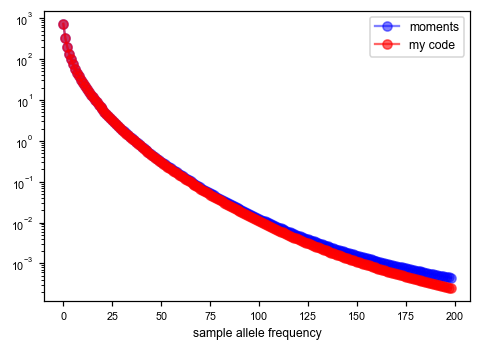

In [1377]:
## CODE TO SHOW 1:1 RELATIONSHIP B/W MOMENTS & MY CALCULATIONS FOR *CHANGING POP SIZE*
# Nc = np.concatenate((np.repeat(2000,500),np.repeat(1000,2000)))
# fsf = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(2000))
# fsf.integrate([2.], .25, gamma=-10, dt_fac=1e-3, theta=400)
# fsf = fsf.project([200])

# %time fst2 = run_mom_iterate_changing3(200, -10/2000, Nc, 400, {}) # -> takes 5 mins for 7000 gens iteration 
# Nc = np.concatenate((np.repeat(2000,500),np.repeat(1000,2000)))
# %time fst3 = run_mom_iterate_changing3(200, -10/2000, Nc, 400, {})
# fst = run_mom_iterate_changing3(200, -20/2000, Nc, 400, {})
# fst2 = mom[:-1,:]
# fst0 = run_mom_iterate_constant(20000, 200, -10/10000, 10000, 400, {})
# plt.imshow(fst2,cmap='OrRd',aspect='auto',norm=colors.LogNorm(vmin=1e-6)); plt.colorbar();

plt.plot(fsf[1:-1],'-ob',label='moments',alpha=0.5); plt.plot(fst2.sum(axis=0)[1:-1]/1000,'-or',label=r'my code',alpha=0.6); plt.xlabel('sample allele frequency'); plt.legend(); plt.semilogy()

### Following manual from moments with Mende from Sierra Leone (MSL, 1000G) data 
#### (checking to see if we get similar DFE)

In [3]:
import pickle 
data = pickle.load(open("../testdata/sampleData/msl_data.bp", "rb"))

fs_syn = data["spectra"]["syn"]
fs_mis = data["spectra"]["mis"]
fs_lof = data["spectra"]["lof"]

u_syn = data["rates"]["syn"]
u_mis = data["rates"]["mis"]
u_lof = data["rates"]["lof"]

print("Diversity:")
print(f"synonymous:\t{fs_syn.pi():.2f}")
print(f"missense:\t{fs_mis.pi():.2f}")
print(f"loss of func:\t{fs_lof.pi():.2f}")

print()
print("Diversity scaled by total mutation rate:")
print(f"synonymous:\t{fs_syn.pi() / u_syn:.2f}")
print(f"missense:\t{fs_mis.pi() / u_mis:.2f}")
print(f"loss of func:\t{fs_lof.pi() / u_lof:.2f}")

Exception ignored in: <_io.FileIO name='../testdata/sampleData/msl_data.bp' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/vc/r8504j4j0ds4cvn52fqczvzh0000gr/T/ipykernel_79019/422844747.py", line 2, in <module>


Diversity:
synonymous:	8452.01
missense:	6991.16
loss of func:	95.16

Diversity scaled by total mutation rate:
synonymous:	58614.15
missense:	20408.81
loss of func:	3718.19


In [4]:
def model_func(params, ns):
    nuA, nuF, TA, TF, p_misid = params
    fs = moments.Demographics1D.snm(ns)
    fs.integrate([nuA], TA)
    nu_func = lambda t: [nuA * np.exp(np.log(nuF / nuA) * t / TF)]
    fs.integrate(nu_func, TF)
    return (1-p_misid) * fs + p_misid * fs[::-1]

p_guess = [2.0, 10.0, 0.3, 0.01, .02]
lower_bound = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]
upper_bound = [10, 100, 1, 1, 1-1e-3]

opt_params = moments.Inference.optimize_log_fmin(
    p_guess, fs_syn, model_func,
    lower_bound=lower_bound, upper_bound=upper_bound)

model = model_func(opt_params, fs_syn.sample_sizes)
opt_theta = moments.Inference.optimal_sfs_scaling(model, fs_syn)
Ne = opt_theta / u_syn / 4

print("optimal demog. parameters:", opt_params)
print("inferred Ne:", f"{Ne:.2f}")

optimal demog. parameters: [2.215 5.298 0.555 0.041 0.020]
inferred Ne: 11372.91


In [71]:
# np.arange(opt_params[2],opt_params[3]+opt_params[2],0.5/Ne)
# plt.plot(np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1]),'ko'); plt.semilogx()
np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])

array([0.000, 0.003, 0.017, 0.050, 0.110, 0.202, 0.332, 0.505, 0.726,
       1.000, 1.122, 1.259, 1.413, 1.585, 1.778, 1.995, 2.239, 2.512,
       2.818, 3.162, 3.548, 3.981, 4.467, 5.012, 5.623, 6.310, 7.079,
       7.943, 8.913, 10.000, 11.220, 12.589, 14.125, 15.849, 17.783,
       19.953, 22.387, 25.119, 28.184, 31.623, 35.481, 39.811, 44.668,
       50.119, 56.234, 63.096, 70.795, 79.433, 89.125, 100.000])

In [350]:
## code to construct demography for a constant + continuous expansion/decline phase
## add an extra burn-in period of 3(?) coalescent time units up front to achieve equilibrium
# burnin = 3
# Nc_mis = []
# Nc_mis.append(np.repeat(opt_params[0]*2*Ne,int((burnin+opt_params[2])*2*Ne)))
# Nc_mis = Nc_mis[0].tolist()
# [Nc_mis.append((opt_params[0]*np.exp(np.log(opt_params[1]/opt_params[0])*(t-(opt_params[2]+burnin))/opt_params[3]))*2*Ne) for t in np.arange(burnin+opt_params[2],burnin+opt_params[3]+opt_params[2],0.5/Ne)]
# Nc_mis = np.array(Nc_mis)
# nu_func_mis = lambda t: [Nc_mis[int(t*2*Ne)]/Ne] # Nc[0] = Ne
# plt.plot(Nc_mis[::-1]/1e5); plt.semilogx(); plt.xlabel('time in gens'); plt.ylabel('pop size in 10k inds')
Nc_mis
# Nc = np.array(list(it.chain(*Nc)))

array([50389.182, 50389.182, 50389.182, ..., 120176.827, 120289.561,
       120402.402])

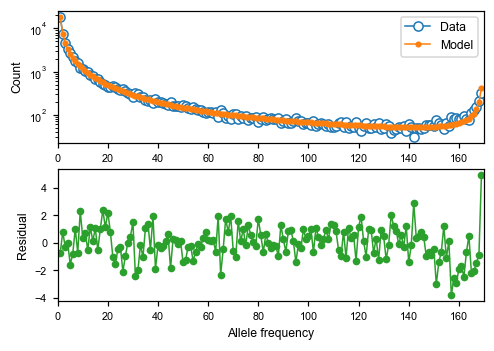

In [6]:
moments.Plotting.plot_1d_comp_multinom(model, fs_syn, residual="linear")

def selection_spectrum(gamma, h=0.5):
    rerun = True
    ns_sim = 100
    while rerun:
        ns_sim = 2 * ns_sim
        fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
        fs = moments.Spectrum(fs)
        fs.integrate([opt_params[0]], opt_params[2], gamma=gamma, h=h)
        nu_func = lambda t: [opt_params[0] * np.exp(
            np.log(opt_params[1] / opt_params[0]) * t / opt_params[3])]
        fs.integrate(nu_func, opt_params[3], gamma=gamma, h=h)
        if abs(np.max(fs)) > 10 or np.any(np.isnan(fs)):
            # large gamma-values can require large sample sizes for stability
            rerun = True
        else:
            rerun = False
    fs = fs.project(fs_syn.sample_sizes)
    fs[fs<0] = -fs[fs<0]
    return fs

spectrum_cache = {}
spectrum_cache[0] = selection_spectrum(0)

gammas = np.logspace(-3, 3, 30)
for gamma in gammas:
    spectrum_cache[gamma] = selection_spectrum(-gamma)

In [7]:
theta_mis = opt_theta * u_mis / u_syn

dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2
    + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=1):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return (1 - 0.0137) * fs + 0.0137 * fs[::-1]

def model_func_missense(params, ns):
    return dfe_func(params, ns, theta=theta_mis)

p_guess = [0.5, 10000]
lower_bound = [1e-4, 1e-1]
upper_bound = [1e1, 1e5]

opt_params_mis = moments.Inference.optimize_log_fmin(
    p_guess, fs_mis, model_func_missense,
    lower_bound=lower_bound, upper_bound=upper_bound,
    multinom=False)

model_mis = model_func_missense(opt_params_mis, fs_mis.sample_sizes)
print("optimal parameters:")
print("shape:", f"{opt_params_mis[0]:.4f}")
print("scale:", f"{opt_params_mis[1]:.1f}")
print("Log-likelihood:", moments.Inference.ll_multinom(model_mis, fs_mis))

optimal parameters:
shape: 0.1591
scale: 2466.4
Log-likelihood: -695.1244578923452


### Trying to recapture the same estimates as above using our procedure and their data

#### Lessons learned:

1. **DO NOT NORMALIZE SFS**
2. Get an estimate of $\Theta$ by some PReFerSim magic (divide the total # of fixed/lost sites by the exp in $\gamma=0\ldots$?)
3. Leave $\gamma$ as positive in the cache, goes from -0.001 to 1000 on logscale
4. Take log10 for the estimates

In [9]:
sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,100]),method='L-BFGS-B',args=({'p_xa_s':spectrum_cache,'gamma':gammas,'sfs':fs_mis,'p_misid':0.0137,'theta':18000}),bounds=((-2,0),(0,4)))

      fun: 693.7730118228467
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.015, 0.006])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 13
     njev: 23
   status: 0
  success: True
        x: array([-0.801, 3.806])

In [447]:
del up_xa_s
up_xa_s = {}
up_xa_s[0] = run_mom_iterate_changing(170, 0, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
for ig, g in enumerate(gammas):
    up_xa_s[g] = run_mom_iterate_changing(170, -g*.5/Ne, Nc_mis, 100, misc = {'dt_fac':0.02, 'adapt_dt':True})
    up_xa_s[g][:,np.arange(1,170)] = up_xa_s[g][:,np.arange(1,170)]/np.sum(up_xa_s[g][:,np.arange(1,170)])

## rescaling to keep mass similar to the SFS for a given gamma 
# up_xa_s[0] = up_xa_s[0]*spectrum_cache[0].sum()/up_xa_s[0].sum()
# for g in gammas:
#     up_xa_s[g] = up_xa_s[g]*spectrum_cache[g].sum()/up_xa_s[g].sum()

## Incorporating error in allele ages using a simple Normal error model

For instance, from GEVA we have a median allele age with lower and upper bounds (95% CI). We can use this information to weight the contribution of each bin in the allele age by a certain probability density drawn from this prior distribution. 

#### How to define a distribution given the median and the 95% CI? 

Maybe the below equation?

$$\sigma = \frac{\ln(a_u) - \ln(a_l)}{2 \times 1.96}$$

## Simulating data under the moments model using a Poisson likelihood

Using $\theta=100$ and $\gamma=-20$ with $n=500$ 

In [450]:
# sd = (np.log(1507)-np.log(1411))*0.5/1.96
# x = range(4000,9000)
# plt.plot(x,sp.stats.lognorm.pdf(x,sd,0,6418),'k'); plt.axvline(4822,color='grey'); plt.axvline(8616,color='grey'); plt.axvline(6418,color='red');
# 1-sp.stats.lognorm.sf(1411,sd,0,1458), 1-sp.stats.lognorm.sf(1507,sd,0,1458)

## input: median values to construct SMSmask + CI values in a different matrix (a tuple for each bin, will prob have to wrap it in a list of lists)
# CI = np.ones((10000,400+1),'i,i')
# nzidx = SMSmask.nonzero()
# for a in nzidx[0]:
#     for i in nzidx[1]:
#         if (a<4):
#             CI[a,i][0] = 1
#             CI[a,i][1] = a+1
#         else:
#             CI[a,i][0] = int(a-0.15*a)
#             CI[a,i][1] = int(a+0.15*a)
# CImask = np.ma.array(CI,mask=mask)

(0.025503879683888453, 0.975499646171225)

In [441]:
# lowci = int(sp.stats.lognorm.ppf(0.05,sd,0,6418)); higci = int(sp.stats.lognorm.ppf(0.95,sd,0,6418))
# prwts = [sp.stats.lognorm.pdf(x,sd,0,6418) for x in range(lowci,higci)]; prwts = prwts/np.sum(prwts)
# get_ll_freqageconstant_werr(1.2,{'sms':SMSmask,'CI':CImask,'gens':10000,'N':10000,'theta':400},400)
# # nzidx = SMSmask.nonzero()
# res = -fsa[SMSmask<1].sum()
# for i in range(821):
#     # sd = (np.log(CImask[nzidx[0][i]][nzidx[1][i]][1])-np.log(CImask[nzidx[0][i]][nzidx[1][i]][0]))/(2*1.96)
#     # lowci = int(np.ceil(sp.stats.lognorm.ppf(0.01,sd,0,nzidx[0][i]))); higci = int(np.ceil(sp.stats.lognorm.ppf(0.99,sd,0,nzidx[0][i])))
#     lowci = CI[nzidx[0][i]][nzidx[1][i]][0]; higci = CI[nzidx[0][i]][nzidx[1][i]][1]+1
#     sd = (np.log(higci)-np.log(lowci))/(2*1.96)
#     prwts = [sp.stats.lognorm.pdf(x,sd,0,nzidx[0][i]) for x in range(lowci,higci)]; prwts = prwts/np.sum(prwts)
#     tempres = np.zeros(higci-lowci)
#     for ia, a in enumerate(range(lowci,higci)):
#         tempres[ia] = -fsa[a][nzidx[1][i]] + np.log(fsa[a][nzidx[1][i]])*SMSmask[a][nzidx[1][i]] - sp.special.gammaln(SMSmask[a][nzidx[1][i]] + 1) + np.log(prwts[ia])
#     res += sp.special.logsumexp(tempres)
# print(res)
# np.nansum(-fsa[:-1,1:] + np.log(fsa[:-1,1:]) * SMSmask[1:,1:] - sp.special.gammaln(SMSmask[1:,1:]+1))

In [12]:
## function call to find MLE using scipy.optimize (and corresponding changes in the next steps for LRT)
## pass in the entire data set & positive gamma and do wrangling inside function
def resample_calculateprob_freqcont(dft, gamma, t=200, n=200, thresh=0.05):
    dft['empty'] = ''
    dft['sXl'] = (dft['Xl']*n).astype('int')
    dft['al'] = 80000+1 - dft['al']
    dft['al'] = dft['al'].astype('int')
    dft = dft.iloc[:,1:]
    datt = dft.to_numpy()
    sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,n+2))[0])
    SMS = np.zeros((80000,n+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(datt)):
        SMS[datt[i,2],datt[i,5]] += 1
    SMSmask = np.ma.array(SMS,mask=mask)

    ressinf = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},n))
    lldubf = get_ll_freqconstant_twogam(np.log10([-gamma[0],-gamma[1]]),{'sfs':sfs,'theta':t,'p_misid':0},n)
    # print(ressinf.fun, lldubf)

    if(chi2.sf(2.*(ressinf.fun - lldubf),1)<thresh):
        probf = 1
    else:
        probf = 0

    ressina = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':80000},n))
    llduba = get_ll_freqageconstant_twogam(np.log10([-gamma[0],-gamma[1]]),{'sms':SMSmask,'theta':t,'N':10000,'gens':80000},n)
    
    # print(ressina.fun, llduba)
    if(chi2.sf(2.*(ressina.fun - llduba),1)<thresh):
        proba = 1
    else:
        proba = 0

    return [probf, proba, ressinf.x, ressina.x]

In [121]:
## what if we only had one gamma in the data set? can the methods reject the model with two gammas? 
# nsims = 15

# gamma = [-1.,-2.,-5.,-10.,-20.,-50.,-100.]
# diffprobsf = np.zeros((len(gamma),nsims))
# diffprobsa = np.zeros((len(gamma),nsims))
# sinpredsf = np.zeros((len(gamma),nsims))
# sinpredsa = np.zeros((len(gamma),nsims))
# for ig, g in enumerate(gamma):
#     for sim in range(nsims):
#         if g in gamma: 
#             with open('simfiles/ParameterFilesConstant.txt',"r") as file:
#                 data = file.readlines()

#             data[0] = 'MutationRate: {:f}\n'.format(40)
#             data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
#             data[7] = 'FilePrefix: outfiles/ConstantSize{}_n400_t40_sim{}\n'.format(-g,sim)

#             with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
#                 file.writelines(data)
            
#             os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

#             dft = pd.read_csv('outfiles/ConstantSize{}_n400_t40_sim{}.3.full_out.txt'.format(-g,sim),sep='\t',header=None,names=['','Xl','s','al','id'])
#         res = resample_calculateprob_freqcont(dft, [g,g], t=40, n=400)
#         diffprobsf[ig,sim] = res[0]; diffprobsa[ig,sim] = res[1]; sinpredsf[ig,sim] = 10**res[2]; sinpredsa[ig,sim] = 10**res[3]
#         print(res)

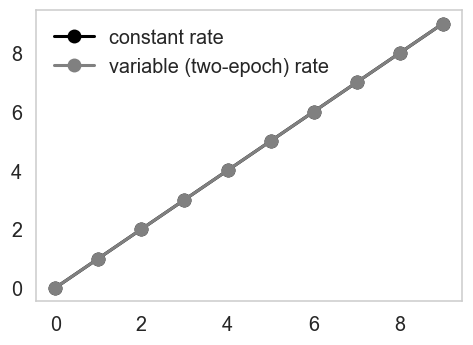

In [157]:
# print(10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},400),).x)
# plt.plot(np.arange(1,402),sfs,); plt.plot(np.arange(1,402),SMSmask.sum(axis=0))
# SMSmask.sum(), sfs.sum()
# print(10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':10000},400),).x)
# SMSmask.sum(), sfs.sum()
plt.plot(range(10),'k-o',label='constant rate')
plt.plot(range(10),'-o',color='grey',label='variable (two-epoch) rate'); plt.legend()

In [ ]:
## estimate gamma using prefresim framework 
num_sims = 10
parestfreq = np.zeros((4,num_sims))
parestage = np.zeros((4,num_sims))
for ig, g in enumerate([-100.,-10.,-1.,0]):
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(400)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*400).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((80000,400+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,402))[0])

        parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},400)).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},400)).x

        print(parestfreq[ig,n], parestage[ig,n])

In [ ]:
## estimate gamma using moments framework 
nsims = 50
parestfreq = np.zeros((4,nsims))
parestage = np.zeros((4,nsims))
for ig, g in enumerate([-100.,-10.,-1., 0]):
    fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=g, theta=400)
    fs = moments.Spectrum(fs)
    fs.integrate([1], 3, gamma=g, theta=400)
    fs = fs.project([100]) 
    fs[fs<0] = -fs[fs<0]

    fsa = run_mom_iterate_constant(20000, 100, g/10000, 10000, 400, {})
    fsa[fsa<0] = -fsa[fsa<0]
    
    for n in range(nsims):
        sfs = np.zeros(len(fs))
        for i in range(1,len(fs)-1):
            sfs[i] = rng.poisson(fs[i],1)

        mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
        SMS = np.zeros_like(fsa)
        for i in range(1,SMS.shape[0]):
            for j in range(1,SMS.shape[1]):
                # if rng.binomial(1,0.25,1):
                SMS[i,j] = rng.poisson(fsa[-i,j],1)
        SMSmask = np.ma.array(SMS,mask=mask)

        parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},100),).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':20000},100),).x
        print(parestfreq[ig,n], parestage[ig,n])

In [166]:
# plt.plot([-50,-0.5,0],np.std(parestfreq,axis=1)/np.std(parestage,axis=1),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--')

# os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims')
parest = np.loadtxt("resfiles/parestnotmmdw9Feb23.txt",delimiter=' ')
parestfreq = parest[:,0].reshape(-1,100)[[0,19,39,-1],:]; parestage = parest[:,1].reshape(-1,100)[[0,19,39,-1],:]
# plt.plot([-100,-10,-1,0],np.std(parestfreq,axis=1)/np.std(parestage,axis=1),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); 
# plt.plot([-100,-10,-1,0],np.std(parestfreq,axis=1)/np.std(parestage,axis=1),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); 

# plt.plot(np.append(np.linspace(0.0, 1.0, num=10)[1:]**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1],np.std(parestfreq,axis=1)/np.std(parestage,axis=1),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of SD'); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); plt.text(1,30,'RMSE\nfreq only: 3.93\nfreq & age: 0.26',fontsize=10)
# plt.plot(-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1],-np.abs(np.std(parestage,axis=1)/np.mean(parestage,axis=1))+np.abs(np.std(parestfreq,axis=1)/np.mean(parestfreq,axis=1)),'k-o', alpha=0.7); plt.xscale('symlog'); plt.ylabel('ratio of CV'); plt.xlabel(r'$\gamma$'); plt.axhline(0,color='grey',ls='--'); plt.ylim((-1,0.1))

# gainmom, gainprf = np.array([1.24191538e+00, 1.84289892e+00, 1.30432199e+00, 7.86562111e-01, 7.21972888e-01, 1.29473337e+00, 9.82358160e-12]), np.array([1.022, 1.28412464, 1.089, 1.02163206, 1.112, 1.53472087, 0.947, 0.97024787, 0.880, 0.9260589, 0.875, 0.88787239, 0.851])
# plt.plot([-100,-30,-10,-3,-1,-0.3,0],gainmom,'-o',color='purple',alpha=0.7,label='moments'); 
# plt.plot([-100,-60,-30,-15,-10,-6,-3,-1.5,-1,-0.6,-0.3,-0.15,0],gainprf,'-o',color='green',alpha=0.7,label='PReFerSim')
# plt.xlabel(r'$\gamma$'); plt.ylabel('ratio of SD'); plt.legend(); plt.xlabel(r'$\gamma$'); plt.axhline(1,color='grey',ls='--'); plt.xscale('symlog'); plt.xlim((-120,0.1))


[]

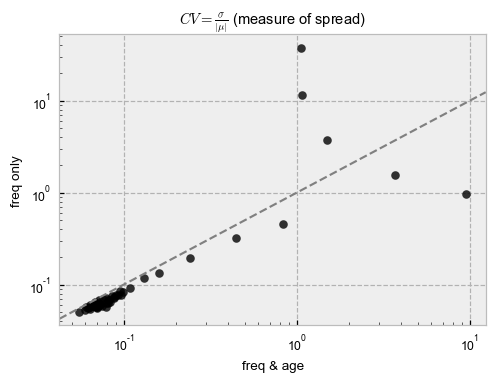

In [55]:
# np.sqrt(np.mean((parestfreq.T - np.append(np.linspace(0.0, 1.0, num=10)[1:]**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1])**2))
# sp.stats.ttest_ind((np.std(parestfreq,axis=1)/np.std(parestage,axis=1))[40:], (np.std(parestfreq,axis=1)/np.std(parestage,axis=1))[20:40])
# plt.plot(-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1],np.abs(np.std(parestfreq,axis=1)/np.mean(parestfreq,axis=1)),'deepskyblue',marker='o'); plt.plot(-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1],np.abs(np.std(parestage,axis=1)/np.mean(parestage,axis=1)),'coral',marker='o'); plt.semilogy(); 
# plt.plot(np.abs(np.std(parestfreq,axis=1)/np.mean(parestfreq,axis=1)),np.abs(np.std(parestage,axis=1)/np.mean(parestage,axis=1)),'ko',alpha=0.8); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.xlabel('freq & age'); plt.ylabel('freq only'); plt.title(r'$CV=\frac{\sigma}{|\mu|}$ (measure of spread)'); plt.loglog()
# -np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1][np.where(np.abs(np.std(parestage,axis=1)/np.mean(parestage,axis=1))>np.abs(np.std(parestfreq,axis=1)/np.mean(parestfreq,axis=1)))[0]]

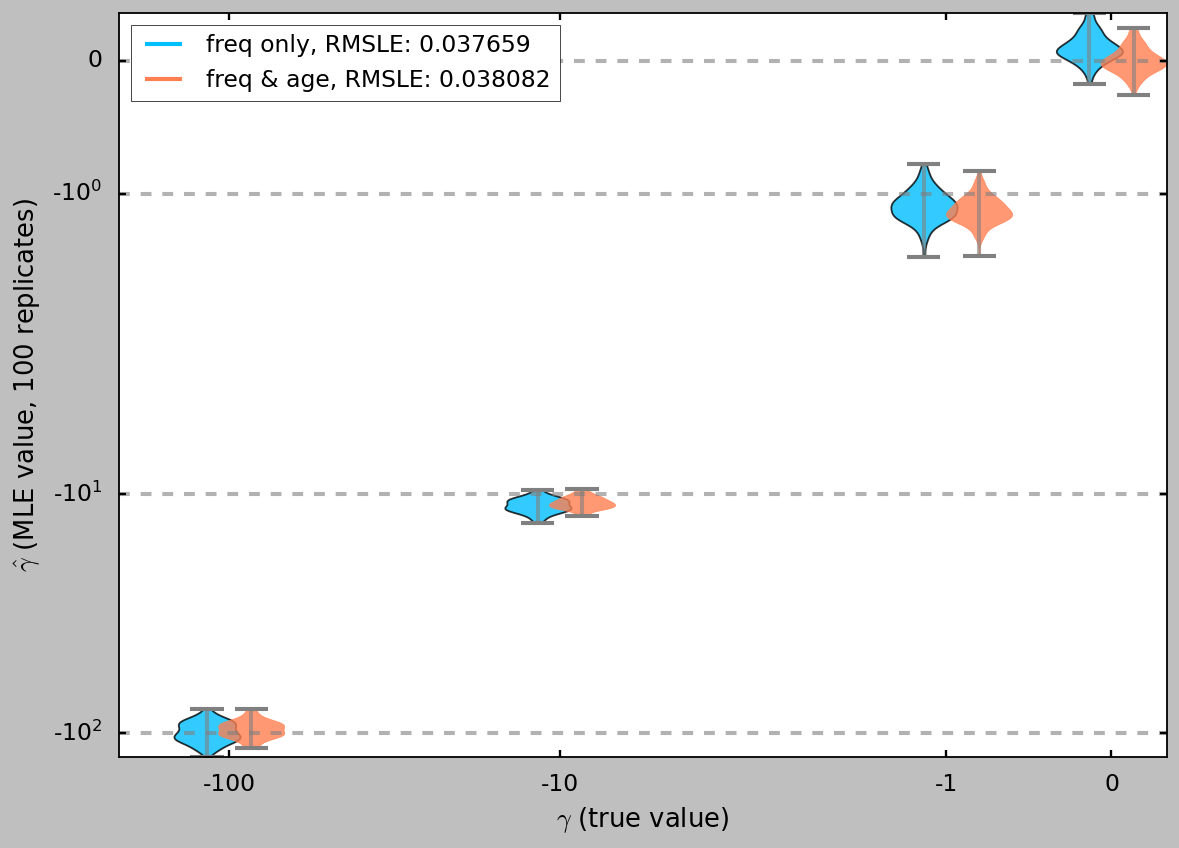

In [233]:
def setViolColors(bp):
    bp['bodies'][0].set_facecolor('deepskyblue')
    bp['bodies'][0].set_alpha(0.8)
    bp['bodies'][0].set_linewidth(1)
    bp['cbars'].set_colors('grey')
    bp['cbars'].set_alpha(0.6)
    bp['cmins'].set_color('grey')
    bp['cmaxes'].set_color('grey')
    # plt.setp(bp['cbars'][0], color='deepskyblue')
    # plt.setp(bp['caps'][1], color='deepskyblue')
    # plt.setp(bp['whiskers'][0], color='deepskyblue')
    # plt.setp(bp['whiskers'][1], color='deepskyblue')
    # plt.setp(bp['fliers'][0], color='deepskyblue')
    # plt.setp(bp['medians'][0], color='deepskyblue')

    plt.setp(bp['bodies'][1], color='coral', alpha=0.8)
    # plt.setp(bp['cbars'][1], color='coral')
    # plt.setp(bp['caps'][3], color='coral')
    # plt.setp(bp['whiskers'][2], color='coral')
    # plt.setp(bp['whiskers'][3], color='coral')
    # plt.setp(bp['fliers'][1], color='coral')
    # plt.setp(bp['medians'][1], color='coral')

fig = plt.figure(dpi=130)
plt.style.use('seaborn-talk')
ax = plt.axes()
s = np.array([-100,-10,-1,0])
#-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,40,endpoint=False)[::-1])[::-1]#np.array([1,10,100]) 

for i in range(len(s)):
    # bp = plt.boxplot([parestfreq[i,~np.isnan(parestfreq[i,:])],parestage[i,~np.isnan(parestage[i,:])]],positions=[3*i+1,3*i+2], widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5),)
    # setBoxColors(bp)
    posn = [0.8,1.2,3.8,4.2,7.3,7.8,8.8,9.2]
    vp = plt.violinplot([parestfreq[i,:],parestage[i,:]],positions=[posn[2*i],posn[2*i+1]], widths=0.6,)
    setViolColors(vp)
    plt.axhline(s[i],color='grey',ls='--',alpha=0.6)

# bp = plt.boxplot([parestfreq0,parestage0],positions=[16,17],widths=0.6,flierprops=dict(marker='x',markersize=5,alpha=0.5))
# setBoxColors(bp) 
# vp = plt.violinplot([-parestfreq[-1,:],-parestage[-1,:]],positions=[9,10],widths=0.6,)
# setViolColors(vp)
# plt.axhline(0.,color='grey',ls='--',alpha=0.6);

# ax.set_xticks([1.5,4.5,7.5,10.5,13.5,16.5]); ax.set_xticklabels(np.ravel(s.tolist()+[0.])); ax.set_yscale('symlog');
ax.set_xticks([1,4,7.5,9]); ax.set_xticklabels(np.ravel(s.tolist())); 
ax.set_yscale('symlog'); ax.set_yticks(s); 

hB, = plt.plot(0,0,color='deepskyblue'); hR, = plt.plot(0,0,color='coral'); #hB.set_visible(True); hR.set_visible(True)
plt.xlabel(r'$\gamma$ (true value)'); plt.ylabel(r'$\hat \gamma$ (MLE value, 100 replicates)'); plt.legend((hB, hR),('freq only','freq & age'),loc='upper left')
plt.legend((hB, hR),('freq only, RMSLE: {:.6f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-parestfreq[:-1,:],axis=1)))**2))), 'freq & age, RMSLE: {:.6f}'.format(np.sqrt(np.mean((np.log10(-s[:-1])-np.log10(np.mean(-parestage[:-1,:],axis=1)))**2)))),loc='upper left')
# plt.savefig("../figs/MLEfreqage2.pdf")

### Changing demographic history (Tennessen et al 2012) with Boyko DFE parameters
DFE: $\text{Beta}(\alpha=0.2,\beta=200)$

In [3]:
# demo = np.loadtxt("/Users/vivaswatshastry/selCoefEst/PReFerSims/simfiles/CEUlike_demo.txt", delimiter=" ", dtype='int')
# Nc = []
# [Nc.append([demo[n,0]]*demo[n,1]) for n in np.arange(len(demo))]
# nu_func = lambda t: [Nc[int(t*10000)]/Nc[0]] 
# Nc = np.array(list(it.chain(*Nc)))
# plt.plot(Nc[::-1]/Nc[0]); plt.loglog(); plt.xlabel('gens ago'); plt.ylabel('pop size (2N)');
# plt.plot([nu_func(t) for t in np.linspace(10.5919,0,len(Nc))]); plt.loglog(); plt.xlabel('coalescent units'); 

# res = []
# for s in np.logspace(-2,2.5,20):
#     fs = moments.LinearSystem_1D.steady_state_1D(9000, gamma=s, theta=40)
#     fs = moments.Spectrum(fs)
#     fs.integrate(nu_func, 10.5919, gamma=s, dt_fac=1e-3, theta=40)
#     fs = fs.project([200])
#     # moments.Plotting.plot_1d_comp_Poisson(fs, sfs)
#     res.append(np.abs(np.sum(moments.Inference.Anscombe_Poisson_residual(fs, sfs))))
# plt.plot(np.logspace(-2,2.5,20)[:-1],res[:-1],'-o'); plt.xscale('log'); plt.xlabel(r'$\gamma$'); plt.ylabel('Anscombe Poisson residual'); plt.axvline(100,color='red')
# fs = moments.LinearSystem_1D.steady_state_1D(9000, gamma=1, theta=40)
# fs = moments.Spectrum(fs)
# fs.integrate(nu_func, 10.59199, gamma=1, dt_fac=1e-4, theta=40)
# fs = fs.project([200])

# plt.plot(fs[1:-1],fsa.sum(axis=0)[1:-1],'-o'); plt.axline((0,0),slope=1,color='grey'); 

In [2442]:
# nuA, nuF, TA, TF = 2.215, 5.298, 0.555, 0.041
# nu = lambda t: [nuA * np.exp(np.log(nuF / nuA) * t / TF)]
# fs = moments.LinearSystem_1D.steady_state_1D(20000, gamma=40, theta=10)
# fs = moments.Spectrum(fs)
# fs.integrate(nu_func, 12.2879, gamma=40, dt_fac=1e-4, theta=10)
# fs.project([200])

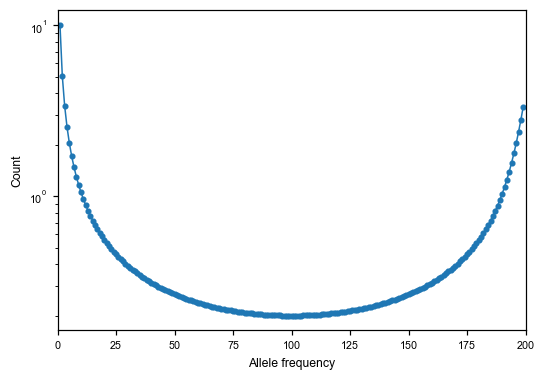

In [6]:
# for s in np.logspace(1,2.5,10):
#     fsa = run_mom_iterate_changing(200, s/Nc[0], Nc, 20, {})
#     print(s,-np.nansum(-fsa[1:,1:] + np.log(fsa[1:,1:]) * SMSmask[1:,1:] - sp.special.gammaln(SMSmask[1:,1:]+1)))
# fsa = run_mom_iterate_changing(200, 50/Nc[0], Nc, 10, {})
moments.Plotting.plot_1d_fs(moments.Spectrum(fsa.sum(axis=0)))
# print(fsa.sum(axis=0)[1:5],SMSmask.sum(axis=0)[1:5])
# print(fsa.sum())
# fsa.sum(axis=0)
# fsa = run_mom_iterate_mom(200, 1, nu_func, 100, 10)

### What if we simulate under the same demography using moments? 

N_old,  [1.000] N_new [2.895]
relative change 1.8948


[]

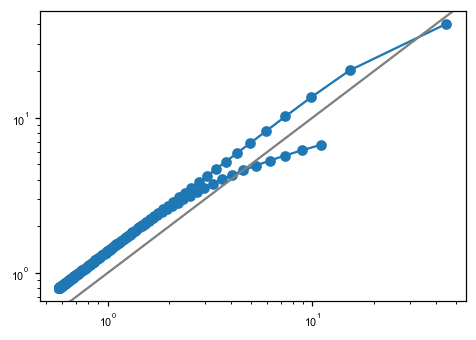

In [237]:
g=20
fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=g, theta=10)
fs = moments.Spectrum(fs)
fs.integrate(nu_func, 10.5919, gamma=g, dt_fac=0.0005, theta=10)
fs = fs.project([200])
fs[fs<0] = 0

plt.plot(fs[1:-1],fsa.sum(axis=0)[1:-1],'-o'); plt.axline((0,0),slope=1,color='grey'); plt.loglog()

In [ ]:
# os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims/')
# dft = pd.read_csv('outfiles/UK10K-1.9.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = len(Nc)+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft = dft.iloc[:,1:]
# datt = dft.to_numpy()

# SMS = np.zeros((len(Nc),200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
fsa = run_mom_iterate_changing(200, 50/Nc[0], Nc, 40, {})
# for i in range(1,len(Nc)):
#     for j in range(1,201):
#         SMS[i,j] = rng.poisson(fsa[i,j],size=1)
# for i in range(len(datt)):
#    SMS[int(datt[i,2]),int(datt[i,4])] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# sfs = np.zeros(200+1,dtype='int16')
# for i in range(1,201):
#     sfs[i] = rng.poisson(fsa[:,i].sum(),size=1)
# sfs = moments.Spectrum(np.histogram(datt[:,4],bins=range(0,202))[0])
# moments.Plotting.plot_1d_fs(moments.Spectrum(sfs))

print(sp.optimize.minimize_scalar(get_ll_freqdemchanging,args=({'sfs':moments.Spectrum(sfs),'theta':20,'nu':nu_func,'T':10.5919},200),bounds=(-100,100)).x)
# print(sp.optimize.minimize_scalar(get_ll_freqagedemchanging,args=({'sms':SMSmask,'theta':40,'Nc':Nc},200),bounds=(-10,20),method='brent').x)
# fsa = run_mom_iterate_changing(200, 0.5*100/Nc[0], Nc, 10, {})[::-1]
# plt.imshow(fsa[:50,:],aspect='auto',interpolation_stage='rgba',cmap='Blues',origin='lower',vmin=1e-10,vmax=np.max(fsa)); plt.colorbar()

In [2423]:
## reading in simulated data + exploratory analysis
# df1 = pd.read_csv("outfiles/Constantgam_DFEneg.9.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# df1['sXl'] = round(df1['Xl']*200)
# df1 = df1.loc[df1['al']<50000,:]
# df1['al'] = 80000+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
# df1['gamma'] = df1['s']*2*10000
# dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(dat)):
#     SMS[dat[i,3],dat[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()
# sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,202))[0])
# moments.Plotting.plot_1d_fs(sfs)

640


In [457]:
# creating a database of P(X, a | s) with dicts for different s values
# del up_xa_s
# up_xa_s = {}
# gammas = np.logspace(-3,2,20)
# up_xa_s[0] = run_mom_iterate_changing(200, 0, Nc/2, 4, {})
# for ig, g in enumerate(gammas):
#     fsa = run_mom_iterate_changing(200, -2*g/(Nc[0]/2), Nc/2, 4, {})
#     fsa[(fsa<0) | (fsa>10)] = 0
#     up_xa_s[g] = fsa
    
# del p_xa_s
# p_xa_s = {}
# for g in np.append(gammas,0):
#     fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-2*g, theta=800)
#     fs = moments.Spectrum(fs)
#     fs.integrate(nu_func, 2.624, gamma=-2*g, dt_fac=0.001, theta=800)
#     fs = fs.project([200])
#     fs[(fs<0) | (fs>1000)] = 0
#     p_xa_s[g] = fs

# up_xa_s = {}
# gammas = np.logspace(-3,3,20)
# up_xa_s[0] = run_mom_iterate_changing(200, 0, Nc, 400, {})[::-1]
# for ig, g in enumerate(gammas):
#     fsa = run_mom_iterate_changing(200, -0.5*g/Nc[0], Nc, 400, {})[::-1]
#     fsa[fsa<0] = 0
#     up_xa_s[g] = fsa
    
# # del p_xa_s
# p_xa_s = {}
# for g in np.append(gammas,0):
#     fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-2*g, theta=800)
#     fs = moments.Spectrum(fs)
#     fs.integrate(nu_func, 7.2489, gamma=-2*g, dt_fac=0.0005, theta=800)
#     fs = fs.project([200])
#     fs[fs<0] = 0
#     p_xa_s[g] = fs

# up_xa_s = {}
# gammas = np.logspace(-3,3,20)
# up_xa_s[0] = run_mom_iterate_constant(80000, 200, 0, 20000, 400, {})[::-1]
# for ig, g in enumerate(gammas):
#     fsa = run_mom_iterate_constant(80000, 200, -g/10000, 20000, 400, {})[::-1]
#     fsa[fsa<0] = 0
#     up_xa_s[g] = fsa
    
# p_xa_s = {}
# for g in np.append(gammas,0):
#     fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-g, theta=400)
#     fs = moments.Spectrum(fs)
#     fs.integrate([1], 3, gamma=-g, theta=400) ## for PReFerSim, we need 0.5Ne instead of Ne
#     fs = fs.project([200]) 
#     fs[fs<0] = 0
#     p_xa_s[g] = fs

In [458]:
# print(sp.optimize.minimize(get_ll_freqagechanging,x0=[0.1,2],method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask},200),bounds=((0,1),(0,4))))
# get_ll_freqagechanging([0.904,0.9],{'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask},200)
# plt.imshow(fsa,aspect='auto',origin='lower'); plt.ylim((0,2000)); plt.xlabel('# of alleles (i)'); plt.colorbar(); plt.ylabel('allele age (a)'); plt.show()
sp.optimize.minimize(get_ll_freqchanging,x0=[0.1,2],method='Nelder-Mead',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs},200),bounds=((0,1),(0,4)))
# get_ll_freqchanging([1,2],{'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,},200)

 final_simplex: (array([[0.188, 2.456],
       [0.188, 2.456],
       [0.188, 2.456]]), array([345.462, 345.462, 345.462]))
           fun: 345.4615803190229
       message: 'Optimization terminated successfully.'
          nfev: 89
           nit: 46
        status: 0
       success: True
             x: array([0.188, 2.456])

In [447]:
# nsims = 16
# estabfr, estabag = np.zeros((nsims,2)), np.zeros((nsims,2))
for n in range(nsims):
    os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 9 > /dev/null 2>&1".format(rng.integers(290522)))

    df1 = pd.read_csv("outfiles/Constantgam_DFEneg.9.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
    df1['sXl'] = round(df1['Xl']*200)
    df1['al'] = 80000+1-df1['al']
    dat = df1.astype('int').to_numpy()

    SMS = np.zeros((80000,200+1),dtype='int16')
    mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
    for i in range(len(dat)):
        SMS[dat[i,3],dat[i,5]] += 1
    SMSmask = np.ma.array(SMS,mask=mask)

    sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,202))[0])
    
    estabag[n,] = sp.optimize.minimize(get_ll_freqagechanging,x0=[0.5,2],method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask}),bounds=((0,1),(0,3))).x
    estabfr[n,] = sp.optimize.minimize(get_ll_freqchanging,x0=[0.1,2],method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,}),bounds=((0,1),(0,3))).x

    # print(estabag[n,],estabfr[n,])
# get_ll_freqchanging(np.log10([0.2,400]),{'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200)
# get_ll_freqagechanging(np.log10([0.8,400]),{'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0},200)

# 10**sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.6,600]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':len(Nc)}),bounds=((-2,0),(0,4))).x, 
# 10**sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.5,500]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,}),bounds=((-2,0),(0,4))).x

[0.232 2.093]
[0.185 2.360]
[0.214 2.051]
[0.232 1.977]
[0.173 2.465]
[0.201 2.078]


In [726]:
# np.median(estabfr,axis=0), np.median(estabag,axis=0)
# np.sum(np.mean((np.log(estabag)-np.log([0.2,200]))**2,axis=0))
# estabag = np.array([[0.253, 1.880],[0.216, 2.155],[0.185, 2.290],[0.172, 2.516],[0.228, 2.068],[0.228, 2.037],[0.201, 2.215], [0.207, 2.150], [0.218, 2.108], [0.232, 2.093], [0.22, 2.15], [0.185, 2.360], [0.214, 2.051], [0.232, 1.977], [0.173, 2.465], [0.201, 2.078]])
# sp.optimize.minimize(get_ll_freqchanging,x0=[0.1,2],method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,}),bounds=((0,1),(0,3))).x

0.2621789531085815

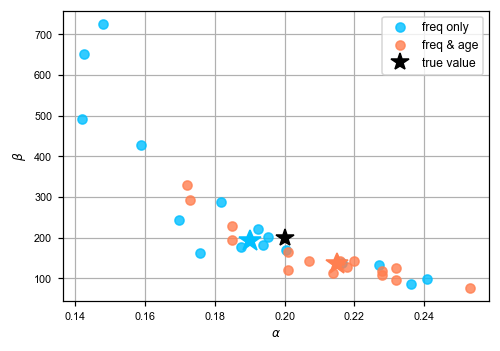

In [701]:
## estabag[:,1] = 10**estabag[:,1]; estabfr[:,1] = 10**estabfr[:,1]
plt.scatter(estabfr[:,0],estabfr[:,1],color='deepskyblue',alpha=0.8,label='freq only'); plt.ylabel(r'$\beta$')
plt.scatter(estabag[:,0],estabag[:,1],color='coral',alpha=0.8,label='freq & age'); plt.plot(0.2,200,'k*',markersize=12,label='true value')
plt.plot(np.median(estabfr[:,0]),np.median(estabfr[:,1]),'*',color='deepskyblue',markersize=15); plt.legend(); plt.xlabel(r'$\alpha$'); 
plt.plot(np.median(estabag[:,0]),np.median(estabag[:,1]),'*',color='coral',markersize=15); plt.grid(); 
# estabag.mean(axis=0), estabfr.mean(axis=0)

In [38]:
# fsa_est = get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},100)
# fsa_est.shape, fsa.shape, SMS.shape
# SMS[:5,:5], fsa[-5:,:5]
# SMS.nonzero()[0][-10:]
# np.allclose(fsa[:19955,:],fsa_est)
# SMS.sum()*2/sfs.sum()
# fsa.sum()*2/fs.sum()
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':120,'N':10000,'p_misid':0,'gens':10000},200),tol=1e-2,bracket=(-2,3))
# get_ll_freqageconstant(np.log10(20),{'sms':SMSmask,'theta':100,'N':10000,'p_misid':0,'gens':10000},200)

     fun: 33820.174146660334
    nfev: 14
     nit: 10
 success: True
       x: 1.3459852991626884

In [ ]:
thetas = np.linspace(1,10,10)
# gtff, ltff = [], []
gtfa, ltfa = [], []
for t in thetas:
    # res = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},250),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ltff.append(res.fun)
    # gtff.append(10**res.x)
    res = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':10000},400))
    ltfa.append(res.fun)
    ## ltfa.append(get_ll_freqageconstant(np.log10(20),{'sms':SMS,'theta':t,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+10},250))
    gtfa.append(10**res.x)

In [16]:
## log-lik 2D surface over theta and gamma
# thetas = np.linspace(0.1,5,10)
# gammas = np.logspace(-1,2,10,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':40000},400)
#         ll2d[it,ig] = get_ll_freqconstant(np.log10(g),{'sfs':sfs,'theta':t,'N':10000,'p_misid':0,},200)

# plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,20,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,20,3),labels=np.round(gammas[::3],1)); 
# plt.axvline(14.7,color='red'); plt.axhline(2.1,color='red'); plt.plot(15,2,'kx')
# np.argwhere(ll2d==np.min(ll2d))
np.append(np.linspace(0.0, 1.0, num=5)**np.exp(1),np.geomspace(100,1,30,endpoint=False)[::-1])

array([0.000, 0.023, 0.152, 0.457, 1.000, 1.166, 1.359, 1.585, 1.848,
       2.154, 2.512, 2.929, 3.415, 3.981, 4.642, 5.412, 6.310, 7.356,
       8.577, 10.000, 11.659, 13.594, 15.849, 18.478, 21.544, 25.119,
       29.286, 34.145, 39.811, 46.416, 54.117, 63.096, 73.564, 85.770,
       100.000])

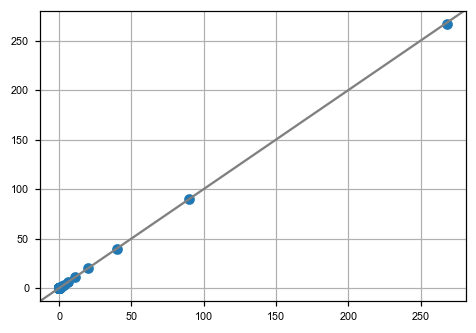

In [806]:
## CODE TO SHOW 1:1 RELATIONSHIP B/W MOMENTS & MY CALCULATIONS
# fsf = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-50, theta=400)
# fsf = moments.Spectrum(fsf)
# fsf.integrate([1], 4, gamma=-50, dt_fac=0.0005, theta=400)
# fsf = fsf.project([200])
# fst = run_mom_iterate_constant(40000, 200, -50/10000, 10000, 400, {})

# fst.sum(axis=0),fsf

# # moments.Plotting.plot_1d_fs(fs)
# plt.scatter(fsf,fst.sum(axis=0)); plt.axline((0,0),color='grey',slope=1); plt.grid()

In [343]:
def get_Kl_div(g, fsa0, sfs0, theta):
    sfs20 = moments.LinearSystem_1D.steady_state_1D(2000, gamma=g, theta=theta)
    sfs20 = moments.Spectrum(sfs20)
    sfs20.integrate([1], 3, gamma=g, theta=theta) ## for PReFerSim, we need 0.5Ne instead of Ne
    sfs20 = sfs20.project([400]) 

    fsa20 = run_mom_iterate_constant(80000, 400, g/10000, 10000, theta, {})

    expresamp = np.sum(np.multiply(sfs20/sfs0,fsa0[:,None]),axis=(1,2))

    plt.plot(np.arange(1,1000)[::-1],expresamp[-1000:-1]/expresamp.sum(),'r+',label=r'resampled from $\mathbb{E}[X_{a.}|\gamma=0]$'); plt.plot(np.arange(1,1000)[::-1],fsa20.sum(axis=1)[-1000:-1]/fsa20.sum(),'k',label=r'$\mathbb{E}[X_{a}|\gamma=$' + '{}]'.format(int(g))); plt.grid(); plt.legend(); plt.xlabel('allele age (gens)'); plt.ylabel('probability'); plt.title('KL divergence: {:.3f}'.format(sp.stats.entropy(expresamp,fsa20.sum(axis=1)))); #plt.semilogx()

    # return [expresamp, fsa20]
    return sp.stats.entropy(fsa20.sum(axis=1),expresamp)

1.3585031316836967e-08

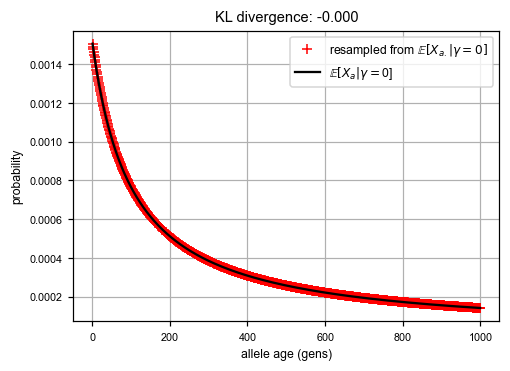

In [345]:
# sfs0 = moments.LinearSystem_1D.steady_state_1D(2000, gamma=0, theta=40)
# sfs0 = moments.Spectrum(sfs0)
# sfs0.integrate([1], 3, gamma=0, theta=40) ## for PReFerSim, we need 0.5Ne instead of Ne
# sfs0 = sfs0.project([400]) 

# fsa0 = run_mom_iterate_constant(80000, 400, 0/10000, 10000, 40, {})

get_Kl_div(0, fsa0, sfs0, 400)

# gam = np.append(-np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,20,endpoint=False)[::-1])[::-1][:-1], np.append(np.linspace(0.0, 1.0, num=10)**np.exp(1),np.geomspace(100,1,20,endpoint=False)[::-1]))
# KLdiv = []
# KLdivrev = []
# for g in gam:
    # KLdiv.append(get_ Kl_div(g, fsa0, sfs0, 40))
    # KLdivrev.append(get_Kl_div(-g, fsa0, sfs0, 40))

In [510]:
def plot_agedist(fsax, sx, ix, cols, xlim):
    gcols = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#737373','#525252','#252525']
    ig = 0
    for i, isx in enumerate(sx):
        if isx > 500/ix:
            plt.plot(fsax[i][:,ix]/fsax[i][:,ix].sum(),color=cols[i])
        else:
            plt.plot(fsax[i][:,ix]/fsax[i][:,ix].sum(),color=gcols[ig])
            ig += 1
    plt.ylabel('probability'); plt.legend(sx,title=r'$\mid \gamma \mid$'); plt.xlim((0,xlim)); plt.xticks(np.linspace(0,xlim,5),labels=np.linspace(0,xlim,5)/10000); plt.xlabel('allele age (in units of 2N gens)'); plt.grid(); plt.title('conditional on i/2n = {:d}%'.format(int(ix/5)))

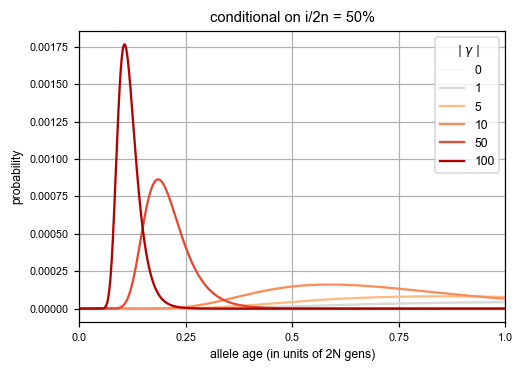

In [516]:
# plt.plot(gam,np.array(KLdiv)+np.array(KLdivrev),'k-o'); plt.ylabel('symmetric KL divergence'); plt.xlabel(r'$\gamma$'); plt.grid(); plt.xscale('symlog')
# np.savetxt('PReFerSims/resfiles/exp.csv',np.vstack((gam,KLdiv,KLdivrev,kurt)).T,delimiter=',',header='gamma,KLdiv,KLdivrev,kurtosis',comments='## kurtosis calculated with 20k gens (gets somewhat smoother with more gens)\n## KL div calculated using theta = 400\n')
# fsa0 = run_mom_iterate_constant(40000, 500, 0/10000, 10000, 200, {})[::-1]
# fsa1 = run_mom_iterate_constant(40000, 500, 1/10000, 10000, 200, {})[::-1]
# fsa5 = run_mom_iterate_constant(40000, 500, 5/10000, 10000, 200, {})[::-1]
# fsa10 = run_mom_iterate_constant(40000, 500, 10/10000, 10000, 200, {})[::-1]
# fsa50 = run_mom_iterate_constant(40000, 500, 50/10000, 10000, 200, {})[::-1]
# fsa100 = run_mom_iterate_constant(40000, 500, 100/10000, 10000, 200, {})[::-1]

# cols = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000']

plot_agedist([fsa0,fsa1,fsa5,fsa10,fsa50,fsa100],[0,1,5,10,50,100], 250, cols, 10000)

In [389]:
# plt.hist(df0['al'],density=True,range=(0,40000)); 
# plt.plot(range(1,4000),fsa20[::-1].sum(axis=1)[1:4000]/fsa20.sum())
# plt.plot(freqresamp[1:20]/freqresamp.sum()); plt.plot(efsa20[1:20])
# plt.hist(df0['sXl'],bins=40,range=(0,40),density=True,label=r'$\gamma=0$'); plt.hist(df0['sXl'].take(resampsites),bins=40,range=(0,40),density=True,alpha=0.7,label=r'resampled for $\gamma=-20$'); plt.plot(range(1,40),efsa20[1:40],'k',alpha=0.8,label=r'$\mathbb{E}[X_i | \gamma=-20]$'); plt.plot(range(1,40),fsa0.sum(axis=0)[1:40]/fsa0.sum(),'grey',ls='--',label=r'$\mathbb{E}[X_i | \gamma=0]$'); plt.xlabel('sample allele frequency'); plt.ylabel('density'); plt.legend(); plt.semilogy()
# plt.hist(df0['al'],bins=300,range=(0,5000),density=True,label=r'$\gamma=0$'); 
# plt.hist(df0['al'].take(resampsites),bins=500,range=(0,2000),density=True,alpha=0.7,label=r'resampled for $\gamma=-20$'); plt.xlabel('allele age (gens)'); plt.ylabel('density'); plt.plot(fsa20[::-1].sum(axis=1)[1:2000]/fsa20.sum(),'k',alpha=0.8,label=r'$\mathbb{E}[X_a | \gamma=-20]$'); plt.legend(); plt.semilogy()
# plt.plot(fsa0[::-1].sum(axis=1)[1:5000]/fsa0.sum(),'grey',ls='--',label=r'$\mathbb{E}[X_a | \gamma=0]$'); 
# plt.plot(freqresamp[1:20]/freqresamp.sum(),fsa0.sum(axis=0)[1:20]/fsa0.sum(),'ko',label=r'expected freq (from $\gamma=0$)'); plt.plot(freqresamp[1:20]/freqresamp.sum(),efsa20[1:20],'*',label=r'expected freq (from $\gamma=-20$)'); plt.grid(); plt.axline((0,0),slope=1,color='grey'); plt.loglog(); plt.xlabel(r'observed freq (subsampled from $\gamma=-20$)'); plt.legend()
# plt.plot(ageresamp[1:20]/ageresamp.sum(),fsa0.sum(axis=1)[-20:-1]/fsa0.sum(),'ko',label=r'expected age (from $\gamma=0$)'); plt.plot(ageresamp[1:20]/ageresamp.sum(),fsa20.sum(axis=1)[-20:-1]/fsa20.sum(),'*',label=r'expected age (from $\gamma=-20$)'); plt.axline((0,0),slope=1,color='grey'); plt.loglog(); plt.xlabel(r'observed age (subsampled from $\gamma=-20$)'); plt.legend()
# kurt = []
# for g in gam:
#     fsa = run_mom_iterate_constant(20000, 400, g/10000, 10000, 400, {})
#     kurt.append(sp.stats.kurtosis(fsa.sum(axis=1)))
# plt.plot(gam,np.array(kurt),'k-o'); plt.ylabel('kurtosis'); plt.xlabel(r'$\gamma$'); plt.grid(); plt.xscale('symlog'); 
# fsa = run_mom_iterate_constant(10000, 400, 100/10000, 10000, 400, {})
# plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-10,vmax=1e-1)); plt.colorbar()

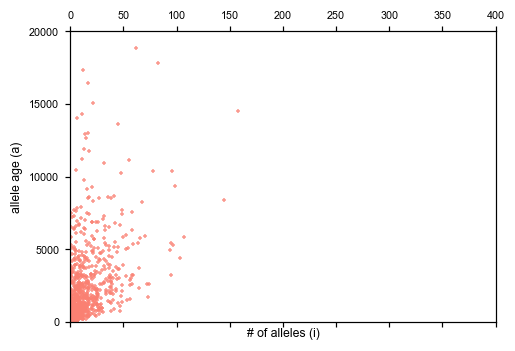

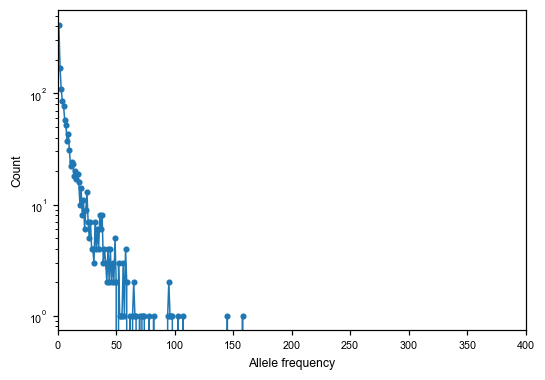

In [109]:
## create a SMS (matrix) instead of SFS
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(dat)):
#     if (dat[i,3]<80000) & (dat[i,5]<200):
#         SMS[dat[i,3],dat[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

# prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
# dadisfs = np.zeros((2000+1,)).astype('int')
# for n in range(0, len(prfsim.columns)-1):
#     dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

# f = open("outfiles/ConstantSize6.95.2.dadi.sfs_out.txt", "w")
# f.write("201 unfolded\n")
# f.write(' '.join(map(str, dadisfs)))
# f.close()

# sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,402))[0])
# moments.Plotting.plot_1d_fs(sfs)

# plt.scatter(np.arange(1,172),fs_mis,color='goldenrod',alpha=0.6,label='moments'); plt.scatter(np.arange(1,172),43*sfs[:171],color='purple',alpha=0.4,label='scaled PReFerSim'); 
# plt.xlabel('Allele frequency'); plt.title('SFS with Gamma(0.18,2000) DFE'); plt.legend(); plt.semilogy(); plt.grid()

In [358]:
# get_ll_freqrecconstant([2.2,1],{'sfs':sfs,'theta':400,'p_misid':0},200)
# sp.optimize.minimize(get_ll_freqrecconstant,x0=[2.3,0.9],method='Powell',args=({'sfs':sfs,'theta':400,'p_misid':0},200),bounds=((-2,3),(0,1)))
# get_ll_freqagerecconstant([0.43,0.01],{'sms':SMSmask,'N':10000,'theta':400,'gens':40000,'p_misid':0},200)
# sp.optimize.minimize(get_ll_freqagerecconstant,x0=[2,0.3],method='Powell',args=({'sms':SMSmask,'N':10000,'theta':400,'gens':40000,'p_misid':0},200),bounds=((-2,3),(0,1)))
# nsims = 15
# estgamf, estgama = np.zeros((nsims,4)), np.zeros((nsims,4))
# esthf, estha = np.zeros((nsims,4)), np.zeros((nsims,4))
# for ih, h in enumerate([0.1,0.3,0.7,0.9]):
#     fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-20, theta=400, h=h)
#     fs = moments.Spectrum(fs)
#     fs.integrate([1], 3, gamma=-20, theta=400, h=h)
#     fs = fs.project([200]) 
#     fs[fs<0] = -fs[fs<0]

#     fsa = run_mom_iterate_constantrec(40000, 200, -20/10000, 10000, 400, h=h)
#     fsa[fsa<0] = -fsa[fsa<0]
    
#     for n in range(nsims):
#         sfs = np.zeros(len(fs))
#         for i in range(1,len(fs)-1):
#             sfs[i] = rng.poisson(fs[i],1)

#         mask = np.zeros_like(fsa); mask[0,:] = 1; mask[:,0] = 1
#         SMS = np.zeros_like(fsa)
#         for i in range(1,SMS.shape[0]):
#             for j in range(1,SMS.shape[1]):
#                 SMS[i,j] = rng.poisson(fsa[-i,j],1)
#         SMSmask = np.ma.array(SMS,mask=mask)  

#         resf = sp.optimize.minimize(get_ll_freqrecconstant,x0=[0.5,0.5],method='Nelder-Mead',args=({'sfs':sfs,'theta':400,'p_misid':0},200),bounds=((-2,3),(0,1))) 
#         estgamf[n,ih] = -10**resf.x[0]; esthf[n,ih] = resf.x[1]

#         resa = sp.optimize.minimize(get_ll_freqagerecconstant,x0=[1,0.25],method='Powell',args=({'sms':SMSmask,'N':10000,'theta':400,'gens':40000,'p_misid':0},200),bounds=((-2,3),(0,1)))
#         estgama[n,ih] = -10**resa.x[0]; estha[n,ih] = resa.x[1]

#     print(estgamf[:,ih].mean(), estgama[:,ih].mean(), esthf[:,ih].mean(), estha[:,ih].mean())

7195.617

## What does the data & expected spectrums look like under different $h$ values?
### Trying underdominance $h=0$, additive $h=1/2$ & overdominance $h=1 \ldots$

(0.0, 1.05)

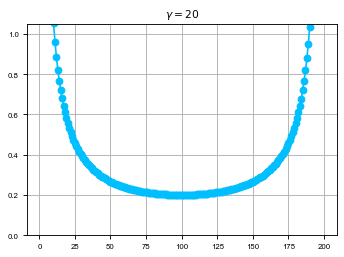

In [1379]:
# fs0 = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-200, theta=400, h=0)
# fs0 = moments.Spectrum(fs0)
# fs0.integrate([1], 3, gamma=-200, theta=400, h=0)
# fs0 = fs0.project([200])

# fs1 = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-200, theta=400, h=1)
# fs1 = moments.Spectrum(fs1)
# fs1.integrate([1], 3, gamma=-200, theta=400, h=1)
# fs1 = fs1.project([200])

# fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-200, theta=400, h=0.5)
# fs = moments.Spectrum(fs)
# fs.integrate([1], 3, gamma=-200, theta=400, h=0.5)
# fs = fs.project([200]) 
# fs[fs<0] = -fs[fs<0]

# plt.plot(range(1,101),fs0[1:101],'k-o',label=r'$h=0$'); plt.plot(range(1,101),fs[1:101],'k-o',alpha=0.6,label=r'$h=1/2$'); plt.semilogy(); plt.plot(range(1,101),fs1[1:101],'k-o',alpha=0.2,label=r'$h=1$'); plt.legend(); plt.xlabel('sample allele freq (i)')

# fsa0 = run_mom_iterate_constantrec(80000, 200, -200/10000, 10000, 400, 0)[::-1]
# fsa1 = run_mom_iterate_constantrec(40000, 200, -20/10000, 10000, 400, 1)[::-1]
# fsa = run_mom_iterate_constant(20000, 200, -20/10000, 10000, 1, {})[::-1]
# fsa = run_mom_iterate_changing(200, -20/10000, Nc, 1, {})[::-1]

# plt.figure(dpi=180)
# plt.imshow(fsa[:10000,:],aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-10),cmap='Blues',origin='lower',interpolation_stage='rgba'); plt.colorbar(); plt.title(r'$\gamma=20$')
plt.figure(dpi=80)
plt.plot(range(1,200),fsa.sum(axis=0)[1:-1],'-o',color='deepskyblue'); plt.title(r'$\gamma=20$'); plt.grid(); plt.ylim((0,1.05))
# plt.imshow(fsa0[:10000,:100]-fsa[:10000,:100],aspect='auto',norm=colors.LogNorm(vmax=1,vmin=1e-10),cmap='viridis',interpolation_stage='rgba'); plt.colorbar(); plt.title(r'$\mathbb{E}[h=0] - \mathbb{E}[h=1/2]$')

# plt.plot(fsa0.sum(axis=0),fs0,'k-o'); plt.axline((0,0),slope=1); plt.xlabel('SFAS (reduced)'); plt.ylabel('SFS'); plt.title(r'$h=0$')
# plt.plot(fsa1.sum(axis=0),fs1,'k-o'); plt.axline((0,0),slope=1); plt.loglog()

# sfs = np.zeros(len(fs1))
# for i in range(1,len(fs1)-1):
#     sfs[i] = rng.poisson(fs1[i],1)

# mask = np.zeros_like(fsa1); mask[0,:] = 1; mask[:,0] = 1
# SMS = np.zeros_like(fsa1)
# for i in range(1,SMS.shape[0]):
#     for j in range(1,SMS.shape[1]):
#         SMS[i,j] = rng.poisson(fsa1[-i,j],1)
# SMSmask = np.ma.array(SMS,mask=mask)

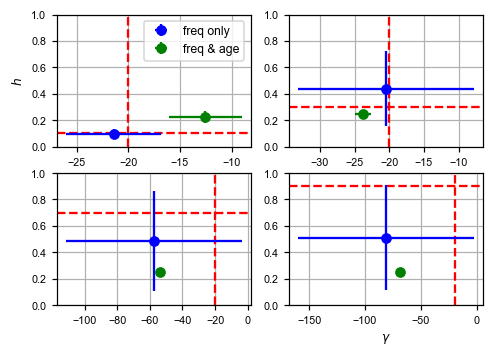

In [160]:
# plt.subplot(2,2,1)
# plt.axhline(0.1,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,0]),np.mean(esthf[:,0]),xerr=np.std(estgamf[:,0]),yerr=np.std(esthf[:,0]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,0]),np.mean(estha[:,0]),xerr=np.std(estgama[:,0]),yerr=np.std(estha[:,0]),fmt='go',label='freq & age');
# plt.ylabel(r'$h$'); plt.legend()

# plt.subplot(2,2,2)
# plt.axhline(0.3,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,1]),np.mean(esthf[:,1]),xerr=np.std(estgamf[:,1]),yerr=np.std(esthf[:,1]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,1]),np.mean(estha[:,1]),xerr=np.std(estgama[:,1]),yerr=np.std(estha[:,1]),fmt='go',label='freq & age');

# plt.subplot(2,2,3)
# plt.axhline(0.7,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,2]),np.mean(esthf[:,2]),xerr=np.std(estgamf[:,2]),yerr=np.std(esthf[:,2]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,2]),np.mean(estha[:,2]),xerr=np.std(estgama[:,2]),yerr=np.std(estha[:,2]),fmt='go',label='freq & age');

# plt.subplot(2,2,4)
# plt.axhline(0.9,color='red',ls='--'); plt.axvline(-20,color='red',ls='--'); plt.grid(); plt.xlabel(r'$\gamma$'); plt.ylim((0,1))
# plt.errorbar(np.mean(estgamf[:,3]),np.mean(esthf[:,3]),xerr=np.std(estgamf[:,3]),yerr=np.std(esthf[:,3]),fmt='bo',label='freq only'); 
# plt.errorbar(np.mean(estgama[:,3]),np.mean(estha[:,3]),xerr=np.std(estgama[:,3]),yerr=np.std(estha[:,3]),fmt='go',label='freq & age');

In [1071]:
num_sims = 10
parestfreq = np.zeros((4,num_sims))
parestage = np.zeros((4,num_sims))
for ig, g in enumerate([-100.,-10.,-1.,0]):
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(400)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*400).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((80000,400+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        # sfs = moments.Spectrum(np.histogram(datt[:,5],bins=range(0,402))[0])

        # parestfreq[ig,n] = sp.optimize.minimize_scalar(get_ll_freq, args=(datt[:,5]), options={'xtol': .05,}).x
        # parestage[ig,n] = sp.optimize.minimize_scalar(get_ll_freqage, args=(datt[:,5], datt[:,2]), options={'xtol': .2}).x
        # parestfreq[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':400,'p_misid':0},400)).x
        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},400)).x

        # print(parestfreq[ig,n])
        print(parestage[ig,n])

-97.80927785821288
-100.46188861093857
-109.92052818491233
-102.17169665979965
-105.58815750940295
-98.60950119642486
-98.85391898706054
-102.46074476986541
-104.61630785782518
-103.34916472291266
-9.383087044297875
-9.86969885738929
-9.924274828812145
-10.927937128201673
-10.35379204927284
-9.880363361794014
-10.12052626901037
-10.079677734186944
-10.11228890535936
-10.122983374931053
-1.0344285090286083
-0.996189055876628
-0.9962359670933811
-1.023785194929546
-1.140137767520585
-1.0410602792066959
-0.9696687110228885
-0.9258720151385285
-0.9152608500026694
-0.9164569876678964
-0.03344581636588298
-0.051399581980583545
-4.718044825727702e-16
-0.0012457590531624152
-0.0012871876716696827
-0.01807591171300446
-4.718044825727702e-16
-4.718044825727702e-16
-4.718044825727702e-16
-0.059578025645469976


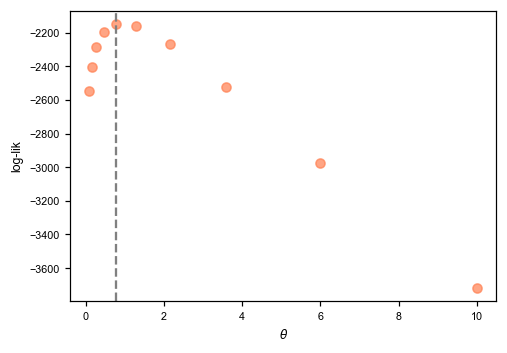

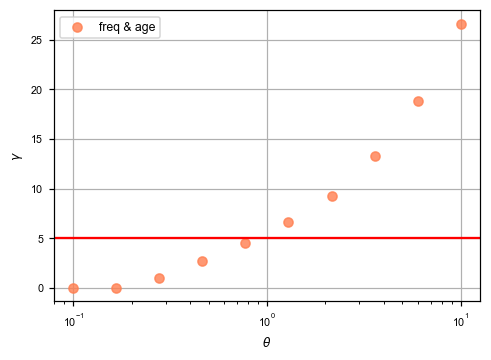

In [341]:
## figuring out the right theta to use for s
thetas = np.logspace(-1,1,10)
# gtff, ltff = [], []
gtfa, ltfa = [], []
for t in thetas:
    # res = sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':t,'p_misid':0},400),tol=1e-1,bracket=(-2,3),options={'maxiter':20})
    # ltff.append(res.fun)
    # gtff.append(10**res.x)
    res = sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':50000},400),tol=1e-2,bracket=(-2,3))
    ltfa.append(res.fun)
    gtfa.append(10**res.x)

# plt.scatter(np.linspace(100,2000,12)[:-1],-np.array(ltff),color='deepskyblue',alpha=0.7,); plt.grid(); plt.xlabel(r'$\theta$'); plt.axvline(np.linspace(100,2000,12)[:-1][np.argmin(ltff)],color='grey',ls='--'); plt.show()
plt.scatter(thetas,-np.array(ltfa),color='coral',alpha=0.7,); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.axvline(thetas[np.argmin(ltfa)],color='grey',ls='--'); plt.show()
# plt.scatter(np.linspace(100,2000,12)[:-1],gtff,color='deepskyblue',alpha=0.8,label='freq only'); plt.axhline(15,color='red'); plt.xlabel(r'$\theta$'); 
plt.scatter(thetas,gtfa,color='coral',alpha=0.8,label='freq & age'); plt.ylabel(r'$\gamma$'); plt.legend(); plt.axhline(5,color='red'); plt.xlabel(r'$\theta$'); plt.grid(); plt.semilogx(); plt.show()
# thetas[np.argmin(ltff)]

In [584]:
## log-lik 2D surface over theta and gamma
thetas = np.logspace(-1,1,12)
gammas = np.logspace(-1,2,12,base=10)
ll2d = np.zeros((len(thetas),len(gammas)))
for it, t in enumerate(thetas):
    for ig, g in enumerate(gammas):
        ll2d[it,ig] = get_ll_freqageconstant(np.log10(g),{'sms':SMSmask,'theta':t,'N':10000,'p_misid':0,'gens':50000},400)

plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,12,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,12,3),labels=np.round(gammas[::3],1)); plt.plot(8,4,'kx'); plt.axvline(8.3,color='red')

# thetas = np.logspace(1,3,12)
# gammas = np.logspace(-1,2,12,base=10)
# ll2d = np.zeros((len(thetas),len(gammas)))
# for it, t in enumerate(thetas):
#     for ig, g in enumerate(gammas):
#         ll2d[it,ig] = get_ll_freqconstant(np.log10(g),{'sfs':sfs,'theta':t,'p_misid':0},400)

# plt.imshow(-ll2d+np.min(ll2d),vmin=-1000); plt.colorbar(); plt.ylabel(r'$\theta$'); plt.xlabel(r'$\gamma$'); plt.yticks(np.arange(0,12,3),labels=np.round(thetas[::3],1)); plt.xticks(np.arange(0,12,3),labels=np.round(gammas[::3],1)); plt.plot(7,9,'kx'); plt.axvline(8.3,color='red'); plt.axhline(8.7,color='red')

KeyboardInterrupt: 

In [651]:
# np.histogram(df1['gamma'],bins=[0,0.5,5,50,200])[0]/len(df1)
# plt.scatter(np.sort(df1['s']),np.sort(sp.stats.gamma.rvs(0.2,scale=400,size=len(df1))/2000))
# sm.qqplot(df1['s']*20000,sp.stats.distributions.gamma(0.2,scale=400),label=r'simulated (shape=0.2,scale=400)',line='45'); 
# sm.qqplot(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=2000$')
# sm.qqplot(sp.stats.gamma.rvs(0.216,scale=5363,size=10000),sp.stats.distributions.gamma(0.18,scale=2000),line='45'); plt.title(r'$\theta=1700$')
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.210,scale=2815,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.091
# np.mean([sp.stats.ks_2samp(sp.stats.gamma.rvs(0.216,scale=1286,size=10000),sp.stats.gamma.rvs(0.18,scale=2000,size=10000))[0] for _ in range(50)]) # statistic=0.047

0.17421

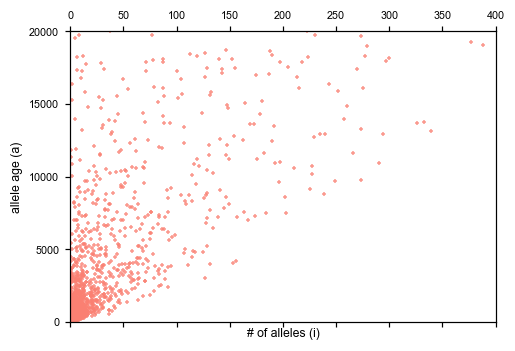

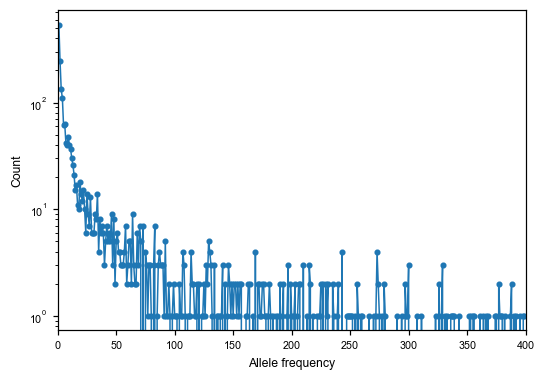

In [56]:
df1 = pd.read_csv("outfiles/gammaHuber17Unif.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
df1['sXl'] = round(df1['Xl']*400)
# df1 = df1.loc[df1['al']<50000,:]
df1['al'] = 50000+1-df1['al']
# df1 = df1.loc[df1['al']<80000,:]
# df1 = df1.loc[df1['sXl']<200,:]
# plt.hist(df1['sXl'],25); plt.xlabel('# of allele copies'); plt.show()
# plt.hist(df1['al'],25); plt.xlabel('age of allele'); plt.show()
df1['gamma'] = df1['s']*2*10000
dat = df1.astype('int').to_numpy()
# plt.hist(-df1['gamma'],50); plt.xlabel('simulated gamma');

SMS = np.zeros((50000,400+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(dat)):
    SMS[dat[i,3],dat[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)
plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.ylim((0,20000)); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.show()

sfs = moments.Spectrum(np.histogram(dat[:,5],bins=range(0,402))[0])
moments.Plotting.plot_1d_fs(sfs)

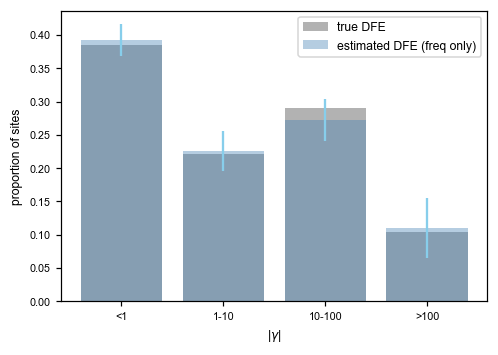

In [700]:
## get simulated distribution of gamma (bins: <1, 1-10, 10-100, >100)
# df1['gamma'] = df1['s']*20000
# plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'observed $\gamma$')
# df1['gamma_inf'] = sp.stats.gamma.rvs(0.174,scale=200,size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>1) & (df1['gamma_inf']<10))/len(df1),np.sum((df1['gamma_inf']>10) & (df1['gamma_inf']<100))/len(df1),np.sum(df1['gamma_inf']>100)/len(df1)],color='steelblue',alpha=0.6,label=r'simulated $\gamma$'); plt.legend()
# plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')

df1['gamma'] = sp.stats.gamma.rvs(0.2,scale=200,size=len(df1)) #df1['s']*20000
plt.bar(np.arange(4),[np.sum(df1['gamma']<1)/len(df1),np.sum((df1['gamma']>1) & (df1['gamma']<10))/len(df1),np.sum((df1['gamma']>10) & (df1['gamma']<100))/len(df1),np.sum(df1['gamma']>100)/len(df1)],color='grey',alpha=0.6,label=r'true DFE')
df1['gamma_inf'] = sp.stats.gamma.rvs(np.median(estabfr[:,0]),scale=np.median(estabfr[:,1]),size=len(df1))
plt.bar(np.arange(4),[np.sum(df1['gamma_inf']<1)/len(df1),np.sum((df1['gamma_inf']>1) & (df1['gamma_inf']<10))/len(df1),np.sum((df1['gamma_inf']>10) & (df1['gamma_inf']<100))/len(df1),np.sum(df1['gamma_inf']>100)/len(df1)],yerr=[np.std([sp.stats.gamma.cdf(1,i[0],scale=i[1]) for i in estabfr]),np.std([sp.stats.gamma.cdf(10,i[0],scale=i[1])-sp.stats.gamma.cdf(1,i[0],scale=i[1],) for i in estabfr]),np.std([sp.stats.gamma.cdf(100,i[0],scale=i[1])-sp.stats.gamma.cdf(10,i[0],scale=i[1],) for i in estabfr]),np.std([1-sp.stats.gamma.cdf(100,i[0],scale=i[1]) for i in estabfr])],color='steelblue',alpha=0.4,label=r'estimated DFE (freq only)',ecolor='skyblue'); 
plt.xticks(np.arange(4),['<1','1-10','10-100','>100']); plt.xlabel(r'|$\gamma$|'); plt.ylabel('proportion of sites')
# df1['gamma_inf3'] = sp.stats.gamma.rvs(np.median(estabag[:,0]),scale=np.median(estabag[:,1]),size=len(df1))
# plt.bar(np.arange(4),[np.sum(df1['gamma_inf3']<1)/len(df1),np.sum((df1['gamma_inf3']>1) & (df1['gamma_inf3']<10))/len(df1),np.sum((df1['gamma_inf3']>10) & (df1['gamma_inf3']<100))/len(df1),np.sum(df1['gamma_inf3']>100)/len(df1)],yerr=[np.std([sp.stats.gamma.cdf(1,i[0],scale=i[1]) for i in estabag]),np.std([sp.stats.gamma.cdf(10,i[0],scale=i[1])-sp.stats.gamma.cdf(1,i[0],scale=i[1],) for i in estabag]),np.std([sp.stats.gamma.cdf(100,i[0],scale=i[1])-sp.stats.gamma.cdf(10,i[0],scale=i[1],) for i in estabag]),np.std([1-sp.stats.gamma.cdf(100,i[0],scale=i[1]) for i in estabag])],color='salmon',alpha=0.4,label=r'estimated DFE (freq & age)',ecolor='salmon');
plt.legend()

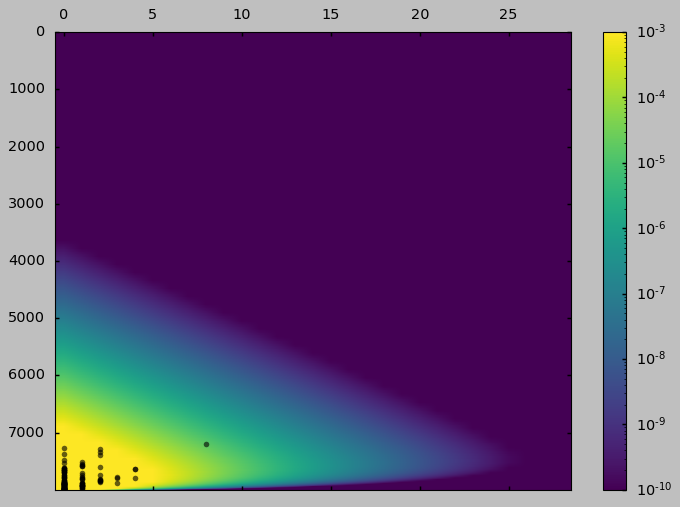

In [246]:
# my_cmap = copy(cm.get_cmap('viridis'))
# my_cmap.set_bad(my_cmap.colors[0])
# Nc = np.linspace(10000,12000,250,dtype='int')
# temp = run_mom_iterate_changing(1000, gamma[-1], Nc[::-1], mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# temp = run_mom_iterate_constant(len(Nc), 1000, gamma[-1]*0.5/Nc[0], 15000, mu, misc = {'dt_fac':0.02, 'adapt_dt':True})
# plt.style.use('classic')
# plt.rcParams['axes.grid'] = False
fsa = run_mom_iterate_constant(20000, 200, -100/10000, 10000, 200, {})
SMS = np.zeros((20000,200))
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(20000):
    for j in range(200):
        SMS[i,j] = rng.poisson(fsa[-i,j],1)
SMSmask = np.ma.array(SMS,mask=mask)
plt.imshow(fsa[-8000:,1:30],aspect='auto',norm=colors.LogNorm(vmax=1e-3,vmin=1e-10),cmap='viridis',interpolation_stage='rgba'); plt.colorbar()
plt.spy(SMSmask[::-1][-8000:,1:30],aspect='auto',color='k',marker='o',markersize=5,alpha=0.6);

In [263]:
sp.optimize.minimize(get_ll_freqagechanging,x0=np.log10([0.5,500]),method='Nelder-Mead',args=({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0,'gens':50000}),)
# sp.optimize.minimize(get_ll_freqchanging,x0=np.log10([0.6,100]),method='L-BFGS-B',args=({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0,},200),bounds=((-2,0),(0,4)))
# theta = np.geomspace(1,50000,20)
# lltheta_age = []
# lltheta_freq = []
# for t in theta:
#     lltheta_freq.append(-get_ll_freqchanging(np.log10([0.2,2000]),({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00,'theta':t})))
#     lltheta_age.append(-get_ll_freqagechanging(np.log10([0.2,2000]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMS,'p_misid':0.00,'theta':t})))

# get_ll_freqchanging(np.log10([0.2,200]),({'p_xa_s':p_xa_s,'gamma':gammas,'sfs':sfs,'p_misid':0.00})) 
# get_ll_freqagechanging(np.log10([0.1,1700]),({'up_xa_s':up_xa_s,'gamma':gammas,'sms':SMSmask,'p_misid':0.00,'gens':50000}))

# plt.scatter(theta, lltheta_freq, color='deepskyblue', alpha=0.6, label='freq only'); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); 
# plt.title(r'holding $(\alpha,\beta)$ at MLE'); plt.yscale('symlog'); plt.semilogx(); plt.grid(); plt.axvline(2000,color='k',ls='--',alpha=0.6,label='simulated')
# plt.scatter(theta, lltheta_age, color='coral', alpha=0.6, label='freq & age'); plt.legend(); 

      fun: 415.39229524255825
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.000, 0.000])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 11
     njev: 24
   status: 0
  success: True
        x: array([-0.722, 2.124])

In [408]:
## set up a framework for estimation of gamma for point DFE
## (all this requires is calculating the res for each value of g)
theta = np.geomspace(100,5000,15)
res_t = np.zeros((len(theta),2))
ll_t = np.zeros((len(theta),2))
nzidx = SMS.nonzero()
for it, t in enumerate(theta):
    res_f = np.zeros(len(gammas))
    res_a = np.zeros(len(gammas))
    for ig, g in enumerate(gammas):
        for i in range(1,len(sfs)-1):
            res_f[ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
        for i in range(len(nzidx[0])):
            res_a[ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)
    ll_t[it,0] = np.nanmax(res_f)
    ll_t[it,1] = np.nanmax(res_a)
    res_t[it,0] = gammas[np.nanargmax(res_f)]
    res_t[it,1] = gammas[np.nanargmax(res_a)]

# theta = np.geomspace(100,1e6,15)
# ll_tf = np.zeros((len(theta),len(gammas)))
# ll_ta = np.zeros((len(theta),len(gammas)))
# nzidx = SMS.nonzero()
# for it, t in enumerate(theta):
#     for ig, g in enumerate(gammas):
#         ll_tf[it,ig] = (-t*p_xa_s[g][:-2] + np.log(t*p_xa_s[g][:-2]) * sfs - sp.special.gammaln(sfs+1)).sum()
#         # for i in range(1,len(sfs)-1):
#         #     ll_tf[it,ig] += -t*p_xa_s[g][i] + np.log(t*p_xa_s[g][i])*sfs[i] - sp.special.gammaln(sfs[i] + 1)
#         for i in range(len(nzidx[0])):
#             ll_ta[it,ig] += -t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]] + np.log(t*1*up_xa_s[g][-nzidx[0][i],nzidx[1][i]])*SMS[nzidx[0][i],nzidx[1][i]] - sp.special.gammaln(SMS[nzidx[0][i],nzidx[1][i]] + 1)

In [617]:
# sp.optimize.minimize_scalar(get_ll_freqconstant,args=({'sfs':sfs,'theta':2000,'p_misid':0}),tol=1e-1,bracket=(-2,3))
# sp.optimize.minimize_scalar(get_ll_freqageconstant,args=({'sms':SMS,'theta':5000,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100}),tol=1e-1,bracket=(-2,3))
# get_ll_freqageconstant(np.log10(1e-20),{'sms':SMS,'theta':100,'N':10000,'p_misid':0,'gens':SMS.nonzero()[0][-1]+100})

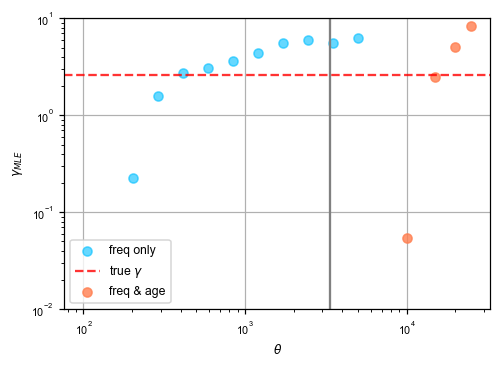

In [626]:
plt.scatter(np.geomspace(100,5000,12),res_t[:,0],alpha=0.6,color='deepskyblue',label='freq only'); plt.axhline(2.64,color='red',ls='--',alpha=0.8,label=r'true $\gamma$'); 
# plt.scatter(theta[ll_t.argmax(axis=0)[0]],res_t[ll_t.argmax(axis=0)[0],0],color='deepskyblue',marker='*',s=200); 
plt.ylim(1e-2,1e1); #plt.xlim(500,1e4)
# plt.scatter(theta[ll_t.argmax(axis=0)[1]],res_t[ll_t.argmax(axis=0)[1],1],color='coral',marker='*',s=200); 
plt.axvline(sfs.sum()*2/p_xa_s[0].sum(),color='grey')
plt.scatter(theta,res_t[:5,1],alpha=0.8,color='coral',label='freq & age'); plt.grid(); plt.loglog(); plt.xlabel(r'$\theta$'); plt.ylabel(r'$\gamma_{MLE}$'); plt.legend(); 

# plt.imshow(ll_tf-np.nanmax(ll_tf),cmap='cividis',vmin=-100); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));
# plt.show()
# plt.imshow(ll_ta-np.nanmax(ll_ta),cmap='cividis',vmin=-200); plt.xticks(range(0,len(gammas),3),np.round(gammas[::3],3)); plt.yticks(range(0,len(theta),2),np.round(theta[::2],1));

In [201]:
## inference procedure for gamma, but only point DFE (does this work first? Yes, it does!)
nsims = 3
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    df1 = pd.read_csv("outfiles/gammaHuber17.2.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=3500)
    df1['sXl'] = df1['Xl']*1000
    df1['al'] = len(Nc) + 1 - df1['al']
    # df1 = df1.loc[df1['al']<50000,:]
    dat = df1.to_numpy(dtype='int64')
    df1['gamma'] = df1['s']*20000

    dub_onlyfreq, dub_onlyage = np.zeros((len(gamma))), np.zeros((len(gamma))) 
    for ig, g in enumerate(gamma):
        dub_onlyfreq[ig] += np.sum(get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2))
        dub_onlyage[ig] += np.sum(get_lp_alxl(up_xa_s, g, dat[:,5], dat[:,3], cutoff=2))

    mlefreq.append(np.argmax(dub_onlyfreq))
    mleage.append(np.argmax(dub_onlyage))

In [356]:
## code to convert PReFerSim sfs_out file to dadi sfs in file
prfsim = pd.read_csv("outfiles/gammaHuber17Unif.2.sfs_out.txt", sep="\t")
dadisfs = np.zeros((200+1,)).astype('int')
for n in range(0, len(prfsim.columns)-1):
    dadisfs[int(prfsim.columns[n].split("/")[0])] = int(prfsim.columns[n].split("/")[1])

f = open("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt", "w")
f.write("201 unfolded\n")
f.write(' '.join(map(str, dadisfs)))
f.close()

In [61]:
## fitdadi framework for DFE inference
# sel_params = [0.5, 1000.]
# lower_bound, upper_bound = [1e-3, 1.], [1, 5000.]
# p0 = dadi.Misc.perturb_params(sel_params,lower_bound=lower_bound,upper_bound=upper_bound)
# def DemoTenn12(params, ns, pts):
#     N1,T1,N2,T2,NC,TC, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 0.01, N1, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, T2, N2, gamma=gamma)
#     nu_func = lambda t: N2*np.exp(np.log(NC/N2)*t/TC)
#     phi = dadi.Integration.one_pop(phi, xx, TC, nu_func, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs
# def DemoConstant(params, ns, pts):
#     N1, gamma = params
#     xx = dadi.Numerics.default_grid(pts)
#     phi = dadi.PhiManip.phi_1D(xx, gamma=gamma)
#     phi = dadi.Integration.one_pop(phi, xx, 6, N1, gamma=gamma)
#     fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
#     fs[fs < 0] = -fs[fs < 0]
#     return fs

# spectra = dadi.DFE.Cache1D([0.5], [1000], DemoConstant, pts_l=[1500], gamma_bounds=(1e-3, 500), gamma_pts=20, verbose=True, mp=False)

# popt, llopt = dadi.Inference.opt(p0, data, spectra.integrate, pts=None, func_args=[DFE.PDFs.gamma, 100], lower_bound=lower_bound, upper_bound=upper_bound, verbose=len(sel_params), maxtime=10, multinom=True)
# print(popt, llopt)

# model_sfs = spectra.integrate(popt, None, DFE.PDFs.gamma, 100, None)
# moments.Plotting.plot_1d_fs(model_sfs)

In [842]:
## moments framework for DFE inference
## A couple of outstanding questions:
# 1. what does dxs do? 
# 2. is theta a big deal here?
# 3. increase the number AND range of gamma values
# 4. include pmis...
# WHY IS moments NOT WORKING EITHER??? is the biggest question
data = moments.Spectrum.from_file("outfiles/gammaHuber17Unif.2.dadi.sfs_out.txt")
def selection_spectrum(gamma, h=0.5):
    ns_sim = 10000
    fs = moments.LinearSystem_1D.steady_state_1D(ns_sim, gamma=gamma, h=h)
    ## define the optimal demo parameters here
    fs = moments.Spectrum(fs)
    fs.integrate([0.5], 6, gamma=gamma)
    fs = fs.project([200]) 
    # fs[fs<0] = np.min(np.abs(fs))
    return fs

# spectrum_cache = {}
# spectrum_cache[0] = selection_spectrum(0)

# gammas = np.logspace(-3, 3, 30)
# for gamma in gammas:
#     spectrum_cache[gamma] = selection_spectrum(-gamma)

# p_xa_s = {}
# for g in list(spectrum_cache.keys()):
#     p_xa_s[-g] = spectrum_cache[g]/np.sum(spectrum_cache[g])
#     p_xa_s[-g][p_xa_s[-g]<0] = 1e-250

# dxs = ((gammas - np.concatenate(([gammas[0]], gammas))[:-1]) / 2 + (np.concatenate((gammas, [gammas[-1]]))[1:] - gammas) / 2)

def dfe_func(params, ns, theta=600):
    alpha, beta = params
    fs = spectrum_cache[0] * sp.stats.gamma.cdf(gammas[0], alpha, scale=beta)
    weights = sp.stats.gamma.pdf(gammas, alpha, scale=beta)
    for gamma, dx, w in zip(gammas, dxs, weights):
        fs += spectrum_cache[gamma] * dx * w
    fs = theta * fs
    return fs 

opt_params_mis = moments.Inference.optimize_log_fmin([0.5,1000], data, dfe_func, lower_bound=[1e-3,1], upper_bound=[1,50000], multinom=True, maxiter=200)
print(opt_params_mis, moments.Inference.ll_multinom(dfe_func(opt_params_mis,200,1000),data))

[0.185 49997.302] -402.212477299273


In [91]:
# sp.special.logsumexp(llage,b=wt), np.log(np.sum(wt*np.exp(llfreq)))
# plt.plot(llfreq-llfreq.max()); plt.plot(llage-llage.max()); plt.ylim((-10,0))
# plt.scatter(dat[:,5], dat[:,3])
# a1, b1 = np.log(np.linspace(0.1,0.5,2)), np.linspace(0.4,0.6,2) # -> this is the ~real deal~
# np.log(np.sum(np.exp(a1)*b1)), sp.special.logsumexp(a1,b=b1)
# llfreq, llage
# get_ll_freqchanging(np.log([1,1]),({'p_xa_s':p_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5]}))

array([0.026, 0.062, 0.082, 0.109, 0.146, 0.195, 0.259, 0.346, 0.461,
       0.615, 0.820, 1.094, 1.459, 1.946, 2.595, 3.460, 4.614, 6.153,
       8.205, 10.941, 14.591, 19.457, 25.946, 34.600, 19.773])

In [46]:
# fsa = np.zeros_like(up_xa_s[gamma[-1]])
# fs = np.zeros_like(p_xa_s[gamma[-1]])
# weights = sp.stats.gamma.pdf(-40000*gamma, alpha[1], scale=beta[1])
# for g, dx, w in zip(gamma, dxs, weights):
#     fs += p_xa_s[g] * dx * w
#     fsa += up_xa_s[g] * dx * w

# plt.imshow(fsa,aspect='auto',norm=colors.LogNorm(vmin=1e-15)); plt.colorbar();  plt.show()
# moments.Plotting.plot_1d_fs(fs)
# get_ll_xl(fs, dat[:,5]), get_ll_xl_al(fsa, dat[:,5], dat[:,2]) 
# get_ll_freqchanging([np.log(0.1),np.log(1000)],{'p_xa_s':p_xa_s,'N0':20000,'gamma':gamma,'sXlred':dat[:,5]})
# get_ll_freqagechanging(np.log([a,b]),({'up_xa_s':up_xa_s,'gamma':gamma,'N0':20000,'sXlred':dat[:,5],'alred':dat[:,3]}))
# get_ll_freqagechanging([np.log(0.1),np.log(1000)],{'up_xa_s':up_xa_s,'N0':40000,'gamma':gamma,'sXlred':dat[:,5],'alred':dat[:,3]})

4678018.894154326

In [888]:
## inference procedure basically means integrating over different values of alpha & beta producing a certain gamma using the appropriate prior (Gamma dist)
## implement sth about weighting (dx*wt) the entire SFS instead of just the sum? and then passing it along to the optim func
alpha, beta = np.linspace(0.1,0.3,10), np.linspace(50,1000,10)
nsims = 1; theta=1
mlefreq, mleage = [], []
for n in range(nsims):
    # os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/1kg_1.5_n10_prefersim.txt 2 > /dev/null 2>&1".format(rng.integers(290522)))
    
    # df1 = pd.read_csv("outfiles/gammaHuber17Const.1.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id']).sample(n=2000)
    # df1['sXl'] = df1['Xl']*1000
    # df1['al'] = 80000+1 - df1['al']
    # dat = df1.astype('int').to_numpy()

    dub_onlyfreq, dub_onlyage = np.zeros((len(alpha),len(beta))), np.zeros((len(alpha),len(beta))) 
    for ia, a in enumerate(alpha):
        for ib, b in enumerate(beta):
            # dub_onlyfreq[ia,ib] = get_ll_freqchanging(np.log10([a,b]),({'p_xa_s':p_xa_s,'gamma':np.logspace(-3,3,15),'sfs':sfs,'p_misid':0.00})) 
            dub_onlyage[ia,ib] = get_ll_freqagechanging(np.log10([a,b]),({'up_xa_s':up_xa_s,'gamma':np.logspace(-2,3,15),'sms':SMSmask,'p_misid':0.00,'gens':50000}))

    # mlefreq.append(np.unravel_index(np.argmin(dub_onlyfreq,axis=None),dub_onlyfreq.shape))
    mleage.append(np.unravel_index(np.argmin(dub_onlyage,axis=None),dub_onlyage.shape))

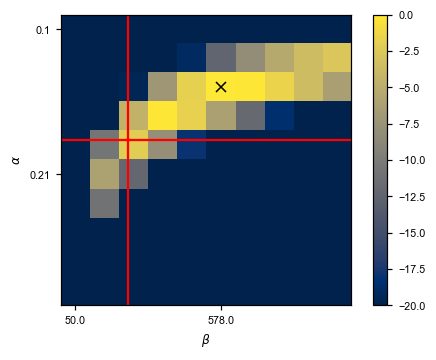

In [917]:
# plt.imshow(dub_onlyfreq-np.nanmax(dub_onlyfreq),vmin=-2); plt.title(r'True value $(\alpha,\beta)=(0.2,400)$'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.show()
# plt.imshow(dub_onlyage-np.max(dub_onlyage),vmin=-10); plt.colorbar(); plt.title(r'True value $(\alpha,\beta)=(0.18,2000)$'); plt.xticks(ticks=range(0,len(beta),3),labels=np.round(beta[::3])); plt.yticks(ticks=range(0,len(beta),3),labels=np.round(alpha[::3],2)); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$')

# plt.imshow(-dub_onlyfreq+np.min(dub_onlyfreq),vmin=-100,cmap='cividis'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.axvline(2.1,color='red'); plt.axhline(1.8,color='red'); plt.plot(mlefreq[0][1],mlefreq[0][0],'kx'); plt.show()
# plt.imshow(-dub_onlyage+np.min(dub_onlyage),vmin=-20,cmap='cividis'); plt.xticks(ticks=range(0,len(beta),5),labels=np.round(beta[::5])); plt.yticks(ticks=range(0,len(beta),5),labels=np.round(alpha[::5],2)); plt.colorbar(); plt.xlabel(r'$\beta$'); plt.ylabel(r'$\alpha$'); plt.axvline(1.8,color='red'); plt.axhline(3.8,color='red'); plt.plot(mleage[0][1],mleage[0][0],'kx'); plt.show()

# get_lp_xl(p_xa_s, g, dat[:,5], cutoff=2)
# ?plt.plot

## Calculating the variance from sims and matching to moments expectation 

We are doing this as we found that there is no gain in information when run on PReFerSim data vs from moments data. Why is this? 

1. A reason could be that the variance in each age & freq bin is not equal to the expectation in each bin (i.e., $\mathbb{V}[X_{ia}] \neq \mathbb{E}[X_{ia}]$) **BUT IT IS EQUAL**

2. This could also be investigated by looking at the ECDF of allele ages and comparing to $\frac{\sum_{a'=1}^{a*}F_{ia'}}{\sum_{a'=1}^{\infty}F_{ia'}}$

In [848]:
# df1 = pd.read_csv("outfiles/ConstantSize10.10.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# ages = np.array(80000+1- df1['al']); freqs = np.array((df1['Xl']*1000).astype('int'))
# df1 = pd.read_csv("outfiles/ConstantSize10.20.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# ages = np.append(ages,np.array(80000+1- df1['al'])); freqs = np.append(freqs,np.array((df1['Xl']*1000).astype('int')))
# df1 = pd.read_csv("outfiles/ConstantSize10.30.full_out.txt",sep='\t',header=None,names=['','Xl','s','al','id'])
# ages = np.append(ages,np.array(80000+1- df1['al'])); freqs = np.append(freqs,np.array((df1['Xl']*1000).astype('int')))
# plt.hist(ages,25)

fsa10 = run_mom_iterate_constant(30000, 10, -10/10000, 10000, 200, {})[::-1] # divide by number of sims
fsa10 = np.pad(fsa10,((1,0),(0,0)))[:-1,:]
# SMS = np.loadtxt('outfiles/SMS_mdw.txt.gz',delimiter=',')
# SMS = SMS.reshape(SMS.shape[0], SMS.shape[1] // 699, 699)
SMSvar = SMS.var(axis=2); SMSmean = SMS.mean(axis=2)

[]

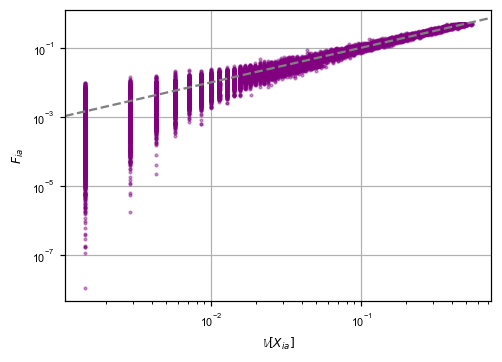

In [910]:
## diff mat b/w exp & var in sims ($X_ia$)
# diffmom = SMSmean - SMSvar
# np.sum(diffmom<0), np.sum(diffmom>0)
# diffmom[diffmom==0] = np.nan
# plt.imshow(SMS[:10000,2:].mean(axis=2),cmap='Greens',aspect='auto'); plt.colorbar(); plt.xticks(range(8),range(2,10)); plt.title(r'$\mathbb{E}[X_{ia}]$')
# plt.imshow(diffmom[:1000,2:],cmap='RdBu',aspect='auto',vmin=-0.01,vmax=0.01); plt.colorbar(); plt.xticks(range(8),range(2,10)); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}]$')
# plt.hist(np.ravel(diffmom[:10000,2:]),20); plt.semilogy(); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}]$ for $i\geq2$')
# plt.plot(np.ravel(diffmom[:10000,2:]),'ko',alpha=0.3)
# np.sum(diffmom[:10000,2:]<0), np.sum(diffmom[:10000,2:]>0)
# plt.scatter(SMSmean[~np.isnan(diffmom)],SMSvar[~np.isnan(diffmom)],color='k',alpha=0.3,s=10); plt.xlabel(r'$\mathbb{E}[X_{ia}]$'); plt.ylabel(r'$\mathbb{V}[X_{ia}]$'); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.grid(); plt.loglog()
# plt.hist(np.ravel(diffmom),25); plt.semilogy(); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}] \forall i$')
# plt.hist(np.ravel(diffmom[:1000,2:]),20); plt.semilogy(); plt.title(r'$\mathbb{E}[X_{ia}] - \mathbb{V}[X_{ia}]$ for $i \geq 2$')
# np.sum(diffmom[:10000,3:]<0), np.sum(diffmom[:10000,3:]>0)

## diff mat b/w var in sims & exp from moments
# diffexp = SMSvar - fsa10
# diffexp[diffmom==0] = np.nan
# plt.hist(np.ravel(diffexp[diffmom!=0]),25); plt.semilogy()
# np.sum(diffexp[diffmom!=0]<0), np.sum(diffexp[diffmom!=0]>0)
# plt.scatter(SMSmean[~np.isnan(diffmom)],fsa10[~np.isnan(diffmom)]/400,color='goldenrod',alpha=0.4,s=3); plt.xlabel(r'$\mathbb{E}[X_{ia}]$'); plt.ylabel(r'$F_{ia}$'); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.grid(); plt.loglog(); plt.show()
plt.scatter(SMSvar[~np.isnan(diffmom)],fsa10[~np.isnan(diffmom)]/400,color='purple',alpha=0.4,s=3); plt.xlabel(r'$\mathbb{V}[X_{ia}]$'); plt.ylabel(r'$F_{ia}$'); plt.axline((0,0),slope=1,color='grey',ls='--'); plt.grid(); plt.loglog()
# plt.imshow(diffexp,cmap='RdBu',aspect='auto',vmin=-0.01,vmax=0.01); plt.colorbar(); plt.title(r'$\mathbb{V}[X_{ia}]-F_{ia}$'); 

In [347]:
## need the same mutation rate and particular frequency bin...
# from statsmodels.distributions.empirical_distribution import ECDF
# fsa10 = run_mom_iterate_constant(50000, 200, -10/10000, 10000, 3, {})[::-1]

# from scipy.stats import rv_discrete
# kst = np.zeros((80,2))
# for i in range(1,80):
#     pk = [fsa10[a,i]/fsa10[:,i].sum() for a in np.arange(1,np.max(ages))]
#     cstm = rv_discrete(name='cstm', values=(np.arange(1,np.max(ages)),pk/np.sum(pk)))
#     if len(ages[freqs==i]>0):
#         kst[i-1,:] = np.ravel(sp.stats.kstest(ages[freqs==i],cstm.rvs(size=10000)))

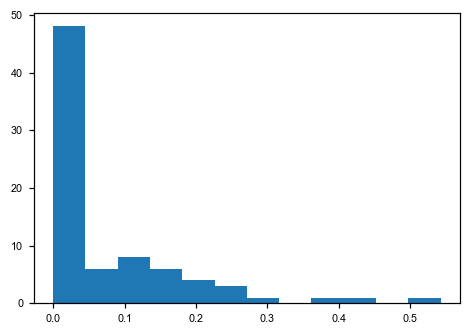

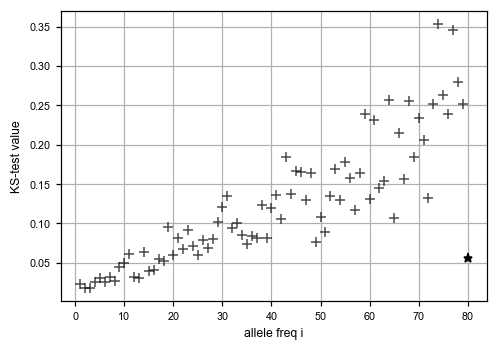

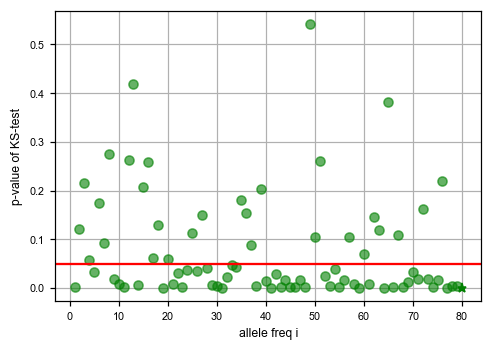

In [64]:
plt.hist(kst[:-1,1],12); plt.show()
plt.plot(range(1,80),kst[:-1,0],'k+',alpha=0.7,); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('KS-test value'); plt.plot(80,0.056,'k*'); plt.show()
plt.plot(range(1,80),kst[:-1,1],'go',alpha=0.6); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('p-value of KS-test'); plt.plot(80,3.5e-4,'g*'); plt.axhline(0.05,color='red')

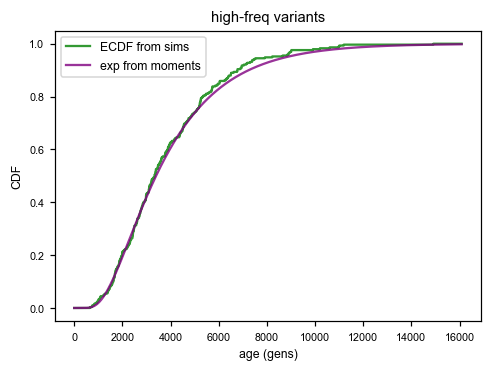

In [152]:
# age_ecdf = ECDF(ages[freqs>=100]); #len(ages[(freqs>=20) & (freqs<=50)]), len(ages[freqs<20]), len(ages[freqs>200])
# totsum = fsa10[:,100:].sum()
# cumsumage = [fsa10[:a,100:].sum()/totsum for a in np.arange(1,np.max(ages))]
plt.plot(np.arange(1,np.max(ages)),[age_ecdf(a) for a in np.arange(1,np.max(ages))],color='green',alpha=0.8,label='ECDF from sims'); plt.plot(np.arange(1,np.max(ages)),cumsumage,color='purple',alpha=0.8,label='exp from moments'); plt.xlabel('age (gens)'); plt.ylabel('CDF'); plt.title('high-freq variants'); plt.legend(); 
# plt.axline((0,0),slope=1,color='grey'); 
# plt.grid(); plt.xlabel(r'$ECDF^{-1}$'); plt.ylabel('cumulative sum of exp.'); plt.title('i >= 100')
# pvals = []
# for i in np.linspace(50,90,15,dtype='int'):
#     totsum = fsa10[:,i:(i+30)].sum() 
#     pk = [fsa10[a,i:(i+30)].sum()/totsum for a in np.arange(1,np.max(ages))]
#     cstm = rv_discrete(name='cstm', values=(np.arange(1,np.max(ages)),pk/np.sum(pk)))
#     pvals.append(sp.stats.kstest(ages[(freqs>=i) & (freqs<(i+30))],cstm.rvs(size=10000))[1])

# import statsmodels
# statsmodels.stats.multitest.multipletests(pvals)

(array([10841.000, 1868.000, 1176.000, 901.000, 761.000, 690.000, 660.000,
        677.000, 777.000, 1649.000]),
 array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000], dtype=float32),
 <BarContainer object of 10 artists>)

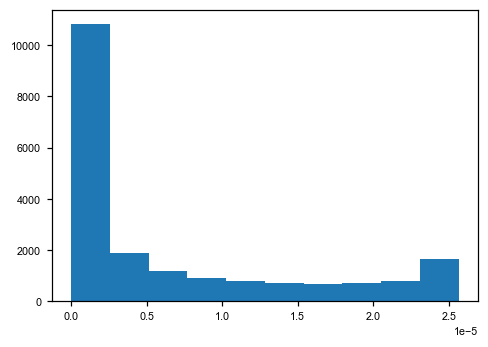

In [433]:
## comparing the mean & variance between the simulations & the expectations Var[X] = E[X^2] - (E[X])^2
# plt.plot(fsa10[:,50]*range(20000),label='i = 50'); plt.axvline(np.sum(fsa10[:,50]*range(20000)),ls='--'); plt.xlabel('ages'); plt.ylabel('PDF')
# plt.plot(fsa10[:,5]*range(20000),label='i = 5',alpha=0.6); plt.axvline(np.sum(fsa10[:,5]*range(20000)),ls='--',color='orange'); plt.legend(); plt.xlim((-1000,25000))

# ageexp = [np.sum(fsa10[:,i]/fsa10[:,i].sum()*range(1,100001)) for i in range(1,200)]
# agemean = [np.mean(ages[freqs==i]) if len(ages[freqs==i])>0 else np.nan for i in range(1,200)]
# plt.plot(range(1,200),ageexp,'go',alpha=0.6,label='moments'); plt.plot(range(1,200),agemean,'o',color='purple',alpha=0.5,label='sims'); plt.legend(); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('mean age (gens)'); 

# agevar = [np.sum(fsa10[:,i]/fsa10[:,i].sum()*np.arange(1,100001)**2) - agemean[i-1]**2 for i in range(1,200)]
# ageempvar = [np.var(ages[freqs==i]) if len(ages[freqs==i])>0 else np.nan for i in range(1,200)]
# plt.plot(range(1,200),np.sqrt(agevar),'go',alpha=0.6,label='moments'); plt.plot(range(1,200),np.sqrt(ageempvar),'o',color='purple',alpha=0.5,label='sims'); plt.legend(); plt.grid(); plt.xlabel('allele freq i'); plt.ylabel('variance in age'); plt.semilogy()

## New model for likelihood of selection coefficient given ages

$\prod_a \sum_{n=1}^N P(X|q,S) \times P(S|p,n) \times P(n|\frac{\theta}{2})$

_Previous model:_ $\prod_a \prod_i P(X_{ia} | \frac{\theta}{2}F_{ia})$

$F_{ia}$ is assuming we start the diffusion with mutational input of 1. 

In [469]:
# sp.stats.multinomial.logpmf(SMSmask[a,:],tempsum,fsa10[i,a]/fsa10[a,:].sum())
# sp.stats.poisson.pmf(30,theta) * sp.stats.binom.pmf(SMSmask[:,i].sum(),30,probseg)
# sp.stats.multinomial.logpmf()
# fsa10 = run_mom_iterate_constant(SMSmask.shape[0], SMSmask.shape[1]-1, -(10**1)/N, N, 3, {})[::-1]

In [478]:
num_sims = 10
# parestfreq = np.zeros((4,num_sims))
# parestage = np.zeros((4,num_sims))
# loglikab = np.zeros((num_sims,2,3))
for ig, g in enumerate([-100.,-10.,-1.,0.]):
    if (ig==1) | (ig==2):
        continue 
    for n in range(num_sims):
        with open('simfiles/ParameterFilesConstant.txt',"r") as file:
            data = file.readlines()

        data[0] = 'MutationRate: {:f}\n'.format(400)
        data[2] = 'DFEPointSelectionCoefficient: {:.8f}\n'.format(-0.5*g/10000)
        data[7] = 'FilePrefix: outfiles/ConstantSize{}\n'.format(-g)

        with open('simfiles/ParameterFilesConstant.txt', 'w') as file:
            file.writelines(data)
        
        os.system("GSL_RNG_SEED={} GSL_RNG_TYPE=mrg ../../PReFerSim/PReFerSim simfiles/ParameterFilesConstant.txt 3 > /dev/null 2>&1 ".format(rng.integers(100496)))

        dft = pd.read_csv('outfiles/ConstantSize{}.3.full_out.txt'.format(-g),sep='\t',header=None,names=['','Xl','s','al','id'])
        dft['empty'] = ''
        dft['sXl'] = (dft['Xl']*200).astype('int')
        dft['al'] = 80000+1 - dft['al']
        dft['al'] = dft['al'].astype('int')
        dft = dft.iloc[:,1:]
        datt = dft.to_numpy()

        SMS = np.zeros((80000,200+1),dtype='int16')
        mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
        for i in range(len(datt)):
            SMS[datt[i,2],datt[i,5]] += 1
        SMSmask = np.ma.array(SMS,mask=mask)

        parestage[ig,n] = -10**sp.optimize.minimize_scalar(get_new_loglik,args=({'theta':3,'SMSmask':SMSmask,'N':8500},200),tol=1e-3).x
        # loglikab[n,:,0] = get_new_loglik(np.log10(5),{'theta':3,'SMSmask':SMSmask,'N':5000},200)
        # loglikab[n,:,1] = get_new_loglik(0,{'theta':3,'SMSmask':SMSmask,'N':5000},200)
        # loglikab[n,:,2] = get_new_loglik(np.log10(0.2),{'theta':3,'SMSmask':SMSmask,'N':5000},200)

        print(parestage[ig,n])

-79.02095025819183
-70.43725376373415
-59.6110717639802
-49.90320483839339
-51.23894415545982
-96.58828311512029
-53.00494681429368
-67.67440008550481
-81.9170549980449
-76.48062902164575
-0.35546239111082956
-0.3579065871111343
-0.1538846565053034
-0.2595444052125074
-0.36483158014181866
-0.13250155514043502
-0.3797150792273616
-0.2914165909704597
-0.45284004390104965
-0.3778947457521079


In [463]:
opts={'theta':3,'SMSmask':SMSmask,'N':10000}
# nll = [get_new_loglik(g, opts, 200) for g in np.linspace(-1,2,12)]; np.argmin(nll)
sp.optimize.minimize_scalar(get_new_loglik,args=(opts,200),tol=1e-3)
# get_new_loglik(np.log10(23), opts, 200)
# nll = [get_ll_freqageconstant(g, {'sms':SMSmask,'theta':3,'N':10000,'p_misid':0,'gens':20000},200) for g in np.linspace(-1,2,12)]; np.argmin(nll)
# plt.plot(np.geomspace(1,100,10),[-get_new_loglik(np.log10(10), {'theta':t,'SMSmask':SMSmask,'N':5000}, 200) for t in np.geomspace(1,100,10)],'ko'); plt.xlabel(r'$\theta$'); plt.ylabel('log-lik'); plt.semilogx(); plt.axvline(6,color='red',ls='--')
# plt.plot(np.geomspace(1,100,10),[10**sp.optimize.minimize_scalar(get_new_loglik,args=({'theta':t,'SMSmask':SMSmask,'N':5000},200),tol=1e-3).x for t in np.geomspace(1,100,10)], 'ko'); plt.xlabel(r'$\theta$'); plt.ylabel(r'$\hat \gamma$'); plt.semilogx(); plt.axhline(10,color='red')

# plt.plot(np.geomspace(2000,20000,12,dtype='int'),[-get_new_loglik(np.log10(10), {'theta':6,'SMSmask':SMSmask,'N':N}, 200) for N in np.geomspace(2000,20000,12,dtype='int')],'ko'); plt.xlabel('N'); plt.ylabel('log-lik'); plt.semilogx(); 
# plt.plot(np.geomspace(2000,20000,10,dtype='int'),[10**sp.optimize.minimize_scalar(get_new_loglik,args=({'theta':6,'SMSmask':SMSmask,'N':N},200),tol=1e-3).x for N in np.geomspace(2000,20000,10,dtype='int')], 'ko'); plt.xlabel('N'); plt.ylabel(r'$\hat \gamma$'); plt.semilogx(); #plt.axhline(10,color='red')

     fun: 5756.0221307169195
    nfev: 14
     nit: 9
 success: True
       x: -0.5641940263181346

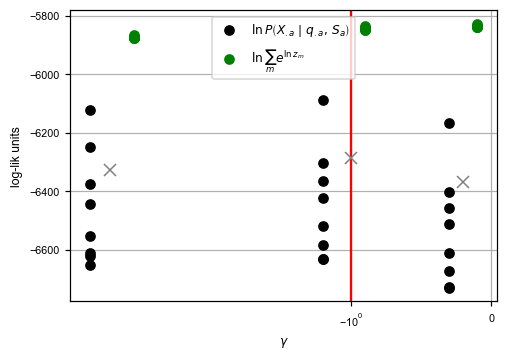

In [392]:
## gamma = -100
# plt.scatter(np.repeat(-195,8),loglikab[:,0,0],color='k',label=r'$\ln P\left(X_{.a}\mid q_{.a},\,S_{a}\right)$'); plt.scatter(np.repeat(-205,8),loglikab[:,1,0]-200,color='g'); 
# plt.scatter(np.repeat(-95,8),loglikab[:,0,1],color='k'); plt.scatter(np.repeat(-105,8),loglikab[:,1,1]-200,color='g',label=r'$\ln\sum_{m}^{}e^{\ln z_{m}}$')
# plt.scatter(np.repeat(-51,8),loglikab[:,0,2],color='k'); plt.scatter(np.repeat(-49,8),loglikab[:,1,2]-200,color='g')
# plt.xlabel(r'$\gamma$'); plt.ylabel('log-lik units'); plt.axvline(-100,color='red'); plt.xscale('symlog'); plt.grid()
# plt.plot([-200,-100,-50],loglikab[:,:,:].mean(axis=0).sum(axis=0),'x',color='grey',markersize=8); plt.legend()

## gamma = -10
# plt.scatter(np.repeat(-45,8),loglikab[:,0,0],color='k',label=r'$\ln P\left(X_{.a}\mid q_{.a},\,S_{a}\right)$'); plt.scatter(np.repeat(-55,8),loglikab[:,1,0]-2000,color='g'); 
# plt.scatter(np.repeat(-8,8),loglikab[:,0,1],color='k'); plt.scatter(np.repeat(-12,8),loglikab[:,1,1]-2000,color='g',label=r'$\ln\sum_{m}^{}e^{\ln z_{m}}$')
# plt.scatter(np.repeat(-1.8,8),loglikab[:,0,2],color='k'); plt.scatter(np.repeat(-2.5,8),loglikab[:,1,2]-2000,color='g')
# plt.xlabel(r'$\gamma$'); plt.ylabel('log-lik units'); plt.axvline(-10,color='red'); plt.xscale('symlog'); plt.grid()
# plt.plot([-50,-10,-2],loglikab[:,:,:].mean(axis=0).sum(axis=0),'x',color='grey',markersize=8); plt.legend()

## gamma = -1
plt.scatter(np.repeat(-6,8),loglikab[:,0,0],color='k',label=r'$\ln P\left(X_{.a}\mid q_{.a},\,S_{a}\right)$'); plt.scatter(np.repeat(-4,8),loglikab[:,1,0]-6000,color='g'); 
plt.scatter(np.repeat(-1.2,8),loglikab[:,0,1],color='k'); plt.scatter(np.repeat(-0.9,8),loglikab[:,1,1]-6000,color='g',label=r'$\ln\sum_{m}^{}e^{\ln z_{m}}$')
plt.scatter(np.repeat(-.3,8),loglikab[:,0,2],color='k'); plt.scatter(np.repeat(-.1,8),loglikab[:,1,2]-6000,color='g')
plt.xlabel(r'$\gamma$'); plt.ylabel('log-lik units'); plt.axvline(-1,color='red'); plt.xscale('symlog'); plt.grid()
plt.plot([-5,-1,-0.2],loglikab[:,:,:].mean(axis=0).sum(axis=0),'x',color='grey',markersize=8); plt.legend()

In [225]:
loglikb = 0
for a in np.where(opts['SMSmask'].sum(axis=1)>0)[0]:
    S = opts['SMSmask'][a,:].sum()
    probseg = fsa10[a,:].sum()/opts['theta']
    lb = int(sp.stats.poisson.ppf(0.01,opts['theta']/2)); ub = int(sp.stats.poisson.ppf(0.99,opts['theta']/2))
    tempsum = np.zeros(ub-lb+1)
    for idn, n in enumerate(range(lb,ub)):
        tempsum[idn] = sp.stats.poisson._logpmf(n,opts['theta']) + sp.stats.binom._logpmf(S,n,probseg)# sp.special.gammaln(n+1) - sp.special.gammaln(n-x+1) + (n-x)*np.log(1-probseg)
    loglikb += sp.special.logsumexp(tempsum)
# plt.plot(np.where(SMSmask.sum(axis=1)>0)[0],[sp.stats.multinomial._logpmf(SMSmask[a,:],SMSmask[a,:].sum(),fsa10[a,:]/fsa10[a,:].sum()) for a in np.where(SMSmask.sum(axis=1)>0)[0]],'k.',alpha=0.6); plt.ylabel('Multinom logpmf'); plt.grid(); plt.xlabel('ages in gens');

In [467]:
def get_new_loglik(g, opts, n=200):
    fsa10 = run_mom_iterate_constant(opts['SMSmask'].shape[0], opts['SMSmask'].shape[1]-1, -(10**g)/opts['N'], opts['N'], opts['theta'], {})[::-1]

    loglika = 0; loglikb = 0
    lb = int(sp.stats.poisson.ppf(0.01,opts['theta'])); ub = int(sp.stats.poisson.ppf(0.99,opts['theta']))
    
    for a in np.where(opts['SMSmask'].sum(axis=1)>0)[0]:
        S = opts['SMSmask'][a,:].sum()
        loglika += sp.stats.multinomial._logpmf(opts['SMSmask'][a,:],S,fsa10[a,:]/fsa10[a,:].sum())

        probseg = fsa10[a,:].sum()/opts['theta']
        
        tempsum = np.zeros(ub-lb+1)
        # tempsum += x*np.log(probseg) - sp.special.gammaln(x+1)
        for idn, n in enumerate(range(lb,ub)):
            tempsum[idn] = sp.stats.poisson._logpmf(n,opts['theta']) + sp.stats.binom._logpmf(S,n,probseg)# sp.special.gammaln(n+1) - sp.special.gammaln(n-x+1) + (n-x)*np.log(1-probseg)
        loglikb += sp.special.logsumexp(tempsum)

    return -(loglika+loglikb)

## Computing posterior distribution for selection coefficient at a single site

$g(\gamma_l | X_l) \propto P(\gamma_l | X_l) = \frac{P(X_l | \gamma_l) P (\gamma_l)}{P(X_l)} \newline$

$\gamma_l \sim \text{Unif}(0.1,200)$, which is just the DFE of new mutations in my simulations

$ P(X_l|\gamma_l) = \frac{\mathcal{L}(\gamma_l; X_l)}{\sum_i^{2n} \mathcal{L}(\gamma_l; X_i)}$, which is just the likelihood of seeing a variant at a certain frequency and a certain selection coefficient *conditional* on segregation

Note: $\theta$ needs to figure in here somewhere, just don't know where

Sampling of posterior can be done with Metropolis-Hastings (can use code borrowed from here: https://python4mpia.github.io/fitting_data/Metropolis-Hastings.html)

$\gamma_n \sim \mathcal{N}(\gamma_o, \sigma^2)$, where $\sigma^2$ is the proposal standard deviation

Acceptance ratio: 
$\rho = \frac{g(\gamma_n | X_l)}{g(\gamma_o | X_l)}$, and accept $\gamma_n$ with probability $\rho$. Set $\gamma_o = \gamma_n$ and propose a new value from the symmetrical normal distribution.  

In [ ]:
## function for computing the likelihood x prior for a specific s/gamma from the prior (do ~2000 draws from a uniform dist for gamma (?) and then normalize)
# sp.stats.gamma.rvs(0.2,scale=200,size=10)
# fs = moments.LinearSystem_1D.steady_state_1D(2000, gamma=-10, theta=40,)
# fs = moments.Spectrum(fs)
# fs.integrate([1], 3, gamma=-10, theta=40) ## for PReFerSim, we need 0.5Ne instead of Ne
# fs = fs.project([200]) 
# fs[fs<0] = -fs[fs<0]

# loglik = -fs[10] + np.log(fs[10]) * 26 - sp.special.gammaln(26+1)
# prior = sp.stats.uniform.logpdf(100,loc=1,scale=1000) # sp.stats.gamma.logpdf(20,0.2,scale=200)

def run_MH_parallel(gini):
    return get_post_gammaMH(gini,1,40000,400,20,)

finalres20 = Parallel(n_jobs=3)(delayed(run_MH_parallel)(x) for x in [0.5,1.,1.5]) # tempres20

0.6833333333333333 0.553 0.5033333333333333


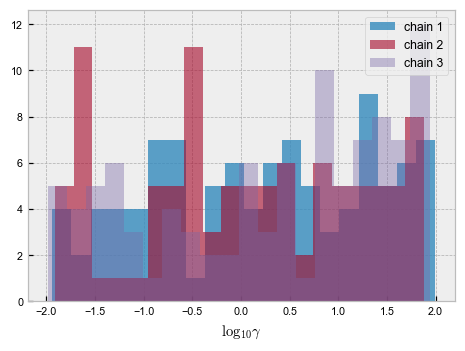

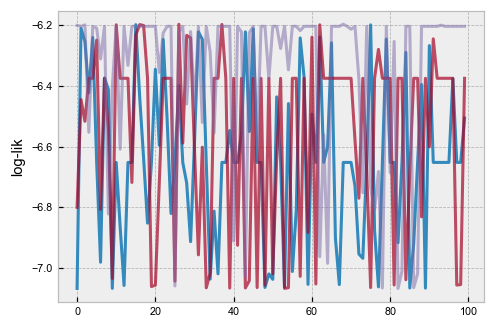

In [102]:
burnin = 1500; thin = 15
print(finalres2[0][2]/len(finalres2[0][0]),finalres2[1][2]/len(finalres2[0][0]),finalres2[2][2]/len(finalres2[0][0]))
plt.hist(np.log10(finalres2[0][0][burnin::thin]),20,alpha=.8,label='chain 1'); plt.hist(np.log10(finalres2[1][0][burnin::thin]),20,alpha=.6,label='chain 2'); plt.hist(np.log10(finalres2[2][0][burnin::thin]),20,alpha=0.4,label='chain 3'); plt.legend(); plt.xlabel(r'$\log_{10} \gamma$'); plt.show()
# plt.hist(np.log10(finalres2[0][0][burnin::thin]),20,alpha=.8,label='chain 1'); plt.hist(np.log10(sp.stats.gamma.rvs(0.2,scale=200,size=1000)),20,alpha=0.4)
plt.plot(finalres2[0][1][burnin::thin]); plt.plot(finalres2[1][1][burnin::thin],alpha=0.7); plt.plot(finalres2[2][1][burnin::thin],alpha=0.5); plt.ylabel('log-lik'); 
# plt.hist(finalres2[0][0][500::15]); plt.hist(finalres2[1][0][500::15],alpha=0.4);plt.hist(finalres2[2][0][500::15],alpha=0.4) 
# plt.hist(np.random.normal(0.8,0.5,200))

0.7196 0.744 0.77415


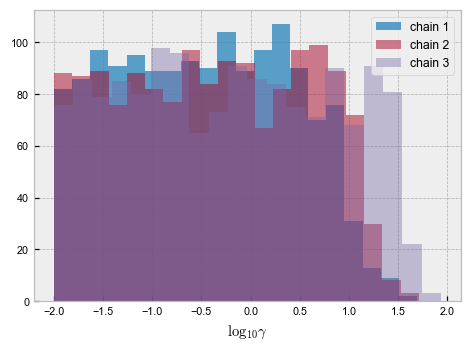

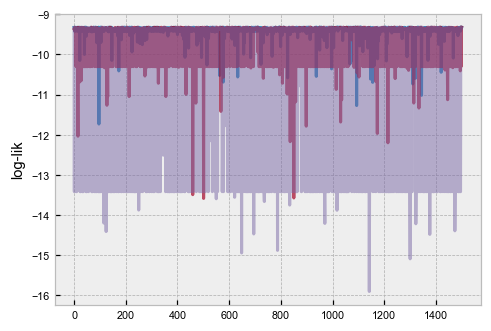

In [107]:
burnin = 25000; thin = 10
print(finalres20[0][2]/len(finalres20[0][0]),finalres20[1][2]/len(finalres20[0][0]),finalres20[2][2]/len(finalres20[0][0]))
# plt.hist(np.append(finalres2[0][0],finalres2[1][0]),20)
plt.hist(np.log10(finalres20[0][0][burnin::thin]),20,alpha=.8,label='chain 1',); plt.hist(np.log10(finalres20[1][0][burnin::thin]),20,alpha=.5,label='chain 2'); plt.hist(np.log10(finalres20[2][0][burnin::thin]),20,alpha=0.4,label='chain 3'); plt.legend(); plt.xlabel(r'$\log_{10} \gamma$'); plt.show()
plt.plot(finalres20[0][1][burnin::thin]); plt.plot(finalres20[1][1][burnin::thin],alpha=0.7); plt.plot(finalres20[2][1][burnin::thin],alpha=0.5); plt.ylabel('log-lik'); 

(array([2693.000, 2720.000, 2663.000, 2663.000, 2608.000, 2528.000,
        2574.000, 2574.000, 2600.000, 2607.000, 2642.000, 2561.000,
        2537.000, 2202.000, 1724.000, 1076.000, 624.000, 275.000, 80.000,
        49.000]),
 array([-1.000, -0.868, -0.736, -0.604, -0.472, -0.340, -0.208, -0.076,
        0.056, 0.188, 0.320, 0.452, 0.584, 0.716, 0.848, 0.980, 1.112,
        1.244, 1.376, 1.508, 1.640]),
 <BarContainer object of 20 artists>)

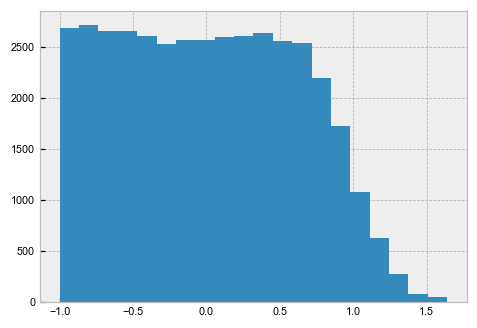

In [97]:
plt.hist(np.log10(np.append(finalres20[0][0],finalres20[1][0])),20)

In [13]:
# plt.hist(np.log10(finalres20[1][0][burnin::thin]),20,alpha=0.6); plt.hist(np.log10(finalres2[1][0][burnin::thin]),20,alpha=0.4)
# plt.plot(finalres20[0][0][burnin::thin]); plt.plot(finalres20[2][0][burnin::thin]); plt.yscale('log')
# import pymc as pm; from mom_functions import *
# logl = LogLike(my_lpf_pymc, 400, 5)
# post_model = pm.Model()
# with post_model:

#     # Priors for unknown model parameter
#     gamma_p = pm.Gamma("gamma", alpha=0.2, beta=1/200) ## rate (beta) = 1/scale

#     gamma = at.as_tensor_variable([gamma_p])

#     lik = pm.Potential("lik", logl(gamma))

#     idata_mh = pm.sample(3000, tune=1000)

# ## plot the traces
# az.plot_trace(idata_mh, lines=[("gamma")])